<a href="https://colab.research.google.com/github/eisbetterthanpi/JEPA/blob/main/locuslab_mpc_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## mpc

### locuslab_mpc

In [ ]:
# https://github.com/locuslab/mpc.pytorch
# https://locuslab.github.io/mpc.pytorch/

In [ ]:
# @title util
# https://github.com/locuslab/mpc.pytorch/blob/master/mpc/util.py
import torch
from torch.autograd import Function, Variable
import operator

def jacobian(f, x, eps):
    if x.ndimension() == 2:
        assert x.size(0) == 1
        x = x.squeeze()
    e = Variable(torch.eye(len(x)).type_as(get_data_maybe(x)))
    J = []
    for i in range(len(x)):
        J.append((f(x + eps*e[i]) - f(x - eps*e[i]))/(2.*eps))
    J = torch.stack(J).transpose(0,1)
    return J

# def expandParam(X, n_batch, nDim):
#     if X.ndimension() in (0, nDim):
#         return X, False
#     elif X.ndimension() == nDim - 1:
#         return X.unsqueeze(0).expand(*([n_batch] + list(X.size()))), True
#     else:
#         raise RuntimeError("Unexpected number of dimensions.")

def bdiag(d):
    assert d.ndimension() == 2
    nBatch, sz = d.size()
    dtype = d.type() if not isinstance(d, Variable) else d.data.type()
    D = torch.zeros(nBatch, sz, sz).type(dtype)
    I = torch.eye(sz).repeat(nBatch, 1, 1).type(dtype).byte()
    D[I] = d.view(-1)
    return D

def bger(x, y):
    return x.unsqueeze(2).bmm(y.unsqueeze(1))

def bmv(X, y):
    return X.bmm(y.unsqueeze(2)).squeeze(2)

def bquad(x, Q):
    return x.unsqueeze(1).bmm(Q).bmm(x.unsqueeze(2)).squeeze(1).squeeze(1)

def bdot(x, y):
    return torch.bmm(x.unsqueeze(1), y.unsqueeze(2)).squeeze(1).squeeze(1)

def eclamp(x, lower, upper):
    # In-place!!
    if type(lower) == type(x):
        assert x.size() == lower.size()
    if type(upper) == type(x):
        assert x.size() == upper.size()
    I = x < lower
    x[I] = lower[I] if not isinstance(lower, float) else lower
    I = x > upper
    x[I] = upper[I] if not isinstance(upper, float) else upper
    return x

def get_data_maybe(x):
    return x if not isinstance(x, Variable) else x.data

# _seen_tables = []
# def table_log(tag, d):
#     # TODO: There's probably a better way to handle formatting here, or a better way altogether to replace this quick hack.
#     global _seen_tables
#     def print_row(r):
#         print('| ' + ' | '.join(r) + ' |')
#     if tag not in _seen_tables:
#         print_row(map(operator.itemgetter(0), d))
#         _seen_tables.append(tag)
#     s = []
#     for di in d:
#         assert len(di) in [2,3]
#         if len(di) == 3:
#             e, fmt = di[1:]
#             s.append(fmt.format(e))
#         else:
#             e = di[1]
#             s.append(str(e))
#     print_row(s)

def get_traj(T, u, x_init, dynamics):
    if isinstance(dynamics, LinDx):
        F = get_data_maybe(dynamics.F)
        f = get_data_maybe(dynamics.f)
        if f is not None:
            assert f.shape == F.shape[:3]
    x = [get_data_maybe(x_init)]
    for t in range(T):
        xt = x[t]
        ut = get_data_maybe(u[t])
        if t < T-1:
            # new_x = f(Variable(xt), Variable(ut)).data
            if isinstance(dynamics, LinDx):
                xut = torch.cat((xt, ut), 1)
                new_x = bmv(F[t], xut)
                if f is not None:
                    new_x += f[t]
            else:
                # print("in get_traj xt: ",xt.requires_grad) # 2 not here
                new_x = dynamics(Variable(xt), Variable(ut)).data
                # print("in get_traj new_x: ",new_x.requires_grad)
            x.append(new_x)
    x = torch.stack(x, dim=0)
    return x

def get_cost(T, u, cost, dynamics=None, x_init=None, x=None):
    assert x_init is not None or x is not None
    if isinstance(cost, QuadCost):
        C = get_data_maybe(cost.C)
        c = get_data_maybe(cost.c)
    if x is None:
        x = get_traj(T, u, x_init, dynamics)
    objs = []
    for t in range(T):
        xt = x[t]
        ut = u[t]
        xut = torch.cat((xt, ut), 1)
        if isinstance(cost, QuadCost):
            obj = 0.5*bquad(xut, C[t]) + bdot(xut, c[t])
        else:
            obj = cost(xut)
        objs.append(obj)
    objs = torch.stack(objs, dim=0)
    total_obj = torch.sum(objs, dim=0)
    return total_obj

def detach_maybe(x):
    if x is None:
        return None
    return x if not x.requires_grad else x.detach()

def data_maybe(x):
    if x is None:
        return None
    return x.data



In [ ]:
# @title pnqp
# https://github.com/locuslab/mpc.pytorch/blob/master/mpc/pnqp.py
import torch

def pnqp(H, q, lower, upper, x_init=None, n_iter=20):
    GAMMA = 0.1
    n_batch, n, _ = H.size()
    pnqp_I = 1e-11*torch.eye(n).type_as(H).expand_as(H)
    def obj(x):
        return 0.5*bquad(x, H) + bdot(q, x)
    if x_init is None:
        if n == 1:
            x_init = -(1./H.squeeze(2))*q
        else:
            # H_lu = H.lu()
            # x_init = -q.unsqueeze(2).lu_solve(*H_lu).squeeze(2) # Clamped in the x assignment.
            H_lu = torch.lu(H.squeeze(0))
            x_init = torch.linalg.lu_solve(*H_lu, -q.unsqueeze(2)).squeeze(2)
    else:
        x_init = x_init.clone() # Don't over-write the original x_init.
    x = eclamp(x_init, lower, upper)
    # Active examples in the batch.
    J = torch.ones(n_batch).type_as(x).byte()
    for i in range(n_iter):
        g = bmv(H, x) + q
        # TODO: Could clean up the types here.
        Ic = (((x == lower) & (g > 0)) | ((x == upper) & (g < 0))).float()
        If = 1-Ic
        if If.is_cuda:
            Hff_I = bger(If.float(), If.float()).type_as(If)
            not_Hff_I = 1-Hff_I
            Hfc_I = bger(If.float(), Ic.float()).type_as(If)
        else:
            Hff_I = bger(If, If)
            not_Hff_I = 1-Hff_I
            Hfc_I = bger(If, Ic)
        g_ = g.clone()
        g_[Ic.bool()] = 0.
        H_ = H.clone()
        H_[not_Hff_I.bool()] = 0.0
        H_ += pnqp_I
        if n == 1:
            dx = -(1./H_.squeeze(2))*g_
        else:
            # H_lu_ = H_.lu()
            H_lu_ = torch.lu(H_)
            dx = -g_.unsqueeze(2).lu_solve(*H_lu_).squeeze(2)
        J = torch.norm(dx, 2, 1) >= 1e-4
        m = J.sum().item() # Number of active examples in the batch.
        if m == 0:
            return x, H_ if n == 1 else H_lu_, If, i
        alpha = torch.ones(n_batch).type_as(x)
        decay = 0.1
        max_armijo = GAMMA
        count = 0
        while max_armijo <= GAMMA and count < 10:
            # Crude way of making sure too much time isn't being spent doing the line search.
            # assert count < 10
            maybe_x = eclamp(x+torch.diag(alpha).mm(dx), lower, upper)
            armijos = (GAMMA+1e-6)*torch.ones(n_batch).type_as(x)
            armijos[J] = (obj(x)-obj(maybe_x))[J]/bdot(g, x-maybe_x)[J]
            I = armijos <= GAMMA
            alpha[I] *= decay
            max_armijo = torch.max(armijos)
            count += 1
        x = maybe_x
    print("[WARNING] pnqp warning: Did not converge") # TODO: Maybe change this to a warning.
    return x, H_ if n == 1 else H_lu_, If, i



In [ ]:
# @title dynamics
# https://github.com/locuslab/mpc.pytorch/blob/master/mpc/dynamics.py
import torch
from torch.autograd import Function, Variable
import torch.nn.functional as F
from torch import nn

# ACTS = {'sigmoid': torch.sigmoid, 'relu': F.relu, 'elu': F.elu,}

# class NNDynamics(nn.Module):
#     def __init__(self, n_state, n_ctrl, hidden_sizes=[100], activation='sigmoid', passthrough=True):
#         super().__init__()
#         self.passthrough = passthrough
#         self.fcs = []
#         in_sz = n_state+n_ctrl
#         for out_sz in hidden_sizes + [n_state]:
#             fc = nn.Linear(in_sz, out_sz)
#             self.fcs.append(fc)
#             in_sz = out_sz
#         self.fcs = nn.ModuleList(self.fcs)
#         assert activation in ACTS.keys()
#         act_f = ACTS[activation]
#         self.activation = activation
#         self.acts = [act_f]*(len(self.fcs)-1)+[lambda x:x] # Activation functions.
#         self.Ws = [y.weight for y in self.fcs]
#         self.zs = [] # Activations.

#     def __getstate__(self):
#         return (self.fcs, self.activation, self.passthrough)

#     def __setstate__(self, state):
#         super().__init__()
#         if len(state) == 2:
#             # TODO: Remove this soon, keeping for some old models.
#             self.fcs, self.activation = state
#             self.passthrough = True
#         else:
#             self.fcs, self.activation, self.passthrough = state
#         act_f = ACTS[self.activation]
#         self.acts = [act_f]*(len(self.fcs)-1)+[lambda x:x] # Activation functions.
#         self.Ws = [y.weight for y in self.fcs]

#     def forward(self, x, u):
#         x_dim, u_dim = x.ndimension(), u.ndimension()
#         if x_dim == 1:
#             x = x.unsqueeze(0)
#         if u_dim == 1:
#             u = u.unsqueeze(0)
#         self.zs = []
#         z = torch.cat((x, u), 1)
#         for act, fc in zip(self.acts, self.fcs):
#             z = act(fc(z))
#             self.zs.append(z)
#         # Hack: Don't include the output.
#         self.zs = self.zs[:-1]
#         if self.passthrough:
#             z += x
#         if x_dim == 1:
#             z = z.squeeze(0)
#         return z

#     def grad_input(self, x, u):
#         assert isinstance(x, Variable) == isinstance(u, Variable)
#         diff = isinstance(x, Variable)
#         x_dim, u_dim = x.ndimension(), u.ndimension()
#         n_batch, n_state = x.size()
#         _, n_ctrl = u.size()
#         if not diff:
#             Ws = [W.data for W in self.Ws]
#             zs = [z.data for z in self.zs]
#         else:
#             Ws = self.Ws
#             zs = self.zs
#         assert len(zs) == len(Ws)-1
#         grad = Ws[-1].repeat(n_batch,1,1)
#         for i in range(len(zs)-1, 0-1, -1):
#             n_out, n_in = Ws[i].size()
#             if self.activation == 'relu':
#                 I = get_data_maybe(zs[i] <= 0.).unsqueeze(2).repeat(1,1,n_in)
#                 Wi_grad = Ws[i].repeat(n_batch,1,1)
#                 Wi_grad[I] = 0.
#             elif self.activation == 'sigmoid':
#                 d = zs[i]*(1.-zs[i])
#                 d = d.unsqueeze(2).expand(n_batch, n_out, n_in)
#                 Wi_grad = Ws[i].repeat(n_batch,1,1)*d
#             else:
#                 assert False
#             grad = grad.bmm(Wi_grad)
#         R = grad[:,:,:n_state]
#         S = grad[:,:,n_state:]
#         if self.passthrough:
#             I = torch.eye(n_state).type_as(get_data_maybe(R)).unsqueeze(0).repeat(n_batch, 1, 1)
#             if diff:
#                 I = Variable(I)
#             R = R + I
#         if x_dim == 1:
#             R = R.squeeze(0)
#             S = S.squeeze(0)
#         return R, S

class CtrlPassthroughDynamics(nn.Module):
    def __init__(self, dynamics):
        super().__init__()
        self.dynamics = dynamics

    def forward(self, tilde_x, u):
        tilde_x_dim, u_dim = tilde_x.ndimension(), u.ndimension()
        if tilde_x_dim == 1:
            tilde_x = tilde_x.unsqueeze(0)
        if u_dim == 1:
            u = u.unsqueeze(0)
        n_ctrl = u.size(1)
        x = tilde_x[:,n_ctrl:]
        # print("in cpd x: ",x.requires_grad)
        xtp1 = self.dynamics(x, u)
        # print("in cpd xtp1: ",xtp1.requires_grad)
        tilde_xtp1 = torch.cat((u, xtp1), dim=1)
        if tilde_x_dim == 1:
            tilde_xtp1 = tilde_xtp1.squeeze()
        return tilde_xtp1

    def grad_input(self, x, u):
        assert False, "Unimplemented"

# class AffineDynamics(nn.Module):
#     def __init__(self, A, B, c=None):
#         super().__init__()
#         assert A.ndimension() == 2
#         assert B.ndimension() == 2
#         if c is not None:
#             assert c.ndimension() == 1
#         self.A = A
#         self.B = B
#         self.c = c

#     def forward(self, x, u):
#         if not isinstance(x, Variable) and isinstance(self.A, Variable):
#             A = self.A.data
#             B = self.B.data
#             c = self.c.data if self.c is not None else 0.
#         else:
#             A = self.A
#             B = self.B
#             c = self.c if self.c is not None else 0.
#         x_dim, u_dim = x.ndimension(), u.ndimension()
#         if x_dim == 1:
#             x = x.unsqueeze(0)
#         if u_dim == 1:
#             u = u.unsqueeze(0)
#         z = x.mm(A.t()) + u.mm(B.t()) + c
#         if x_dim == 1:
#             z = z.squeeze(0)
#         return z

#     def grad_input(self, x, u):
#         n_batch = x.size(0)
#         A, B = self.A, self.B
#         A = A.unsqueeze(0).repeat(n_batch, 1, 1)
#         B = B.unsqueeze(0).repeat(n_batch, 1, 1)
#         if not isinstance(x, Variable) and isinstance(A, Variable):
#             A, B = A.data, B.data
#         return A, B



In [ ]:
# @title lqr_step
# https://github.com/locuslab/mpc.pytorch/blob/master/mpc/lqr_step.py
# time-varying linear control (LQR) problem
import torch
from torch.autograd import Function, Variable
import numpy as np
import numpy.random as npr
from collections import namedtuple
import time

LqrBackOut = namedtuple('lqrBackOut', 'n_total_qp_iter')
LqrForOut = namedtuple('lqrForOut', 'objs full_du_norm alpha_du_norm mean_alphas costs')

def LQRStep(n_state, n_ctrl, T,
            u_lower=None, u_upper=None,
            u_zero_I=None,
            delta_u=None,
            linesearch_decay=0.2,
            max_linesearch_iter=10,
            true_cost=None,
            true_dynamics=None,
            delta_space=True,
            current_x=None, current_u=None,
            verbose=0,
            back_eps=1e-3,
            no_op_forward=False):
    """A single step of the box-constrained iLQR solver.
        Required Args:
            n_state, n_ctrl, T
            x_init: The initial state [n_batch, n_state]
        Optional Args:
            u_lower, u_upper: The lower- and upper-bounds on the controls.
                These can either be floats or shaped as [T, n_batch, n_ctrl]
                TODO: Better support automatic expansion of these.
            TODO"""
    def lqr_backward(ctx, C, c, F, f):
        n_batch = C.size(1)
        u = ctx.current_u
        Ks = []
        ks = []
        prev_kt = None
        n_total_qp_iter = 0
        Vtp1 = vtp1 = None
        for t in range(T-1, -1, -1):
            if t == T-1:
                Qt = C[t]
                qt = c[t]
            else:
                Ft = F[t]
                Ft_T = Ft.transpose(1,2)
                Qt = C[t] + Ft_T.bmm(Vtp1).bmm(Ft)
                if f is None or f.nelement() == 0:
                    qt = c[t] + Ft_T.bmm(vtp1.unsqueeze(2)).squeeze(2)
                else:
                    ft = f[t]
                    qt = c[t] + Ft_T.bmm(Vtp1).bmm(ft.unsqueeze(2)).squeeze(2) + Ft_T.bmm(vtp1.unsqueeze(2)).squeeze(2)
            Qt_xx = Qt[:, :n_state, :n_state]
            Qt_xu = Qt[:, :n_state, n_state:]
            Qt_ux = Qt[:, n_state:, :n_state]
            Qt_uu = Qt[:, n_state:, n_state:]
            qt_x = qt[:, :n_state]
            qt_u = qt[:, n_state:]
            if u_lower is None:
                if n_ctrl == 1 and u_zero_I is None:
                    Kt = -(1./Qt_uu)*Qt_ux
                    kt = -(1./Qt_uu.squeeze(2))*qt_u
                else:
                    if u_zero_I is None:
                        Qt_uu_inv = [torch.pinverse(Qt_uu[i]) for i in range(Qt_uu.shape[0])]
                        Qt_uu_inv = torch.stack(Qt_uu_inv)
                        Kt = -Qt_uu_inv.bmm(Qt_ux)
                        kt = bmv(-Qt_uu_inv, qt_u)
                        # Qt_uu_LU = Qt_uu.lu()
                        # Kt = -Qt_ux.lu_solve(*Qt_uu_LU)
                        # kt = -qt_u.lu_solve(*Qt_uu_LU)
                    else:
                        # Solve with zero constraints on the active controls.
                        I = u_zero_I[t].float()
                        notI = 1-I
                        qt_u_ = qt_u.clone()
                        qt_u_[I.bool()] = 0
                        Qt_uu_ = Qt_uu.clone()
                        if I.is_cuda:
                            notI_ = notI.float()
                            Qt_uu_I = (1-bger(notI_, notI_)).type_as(I)
                        else:
                            Qt_uu_I = 1-bger(notI, notI)
                        Qt_uu_[Qt_uu_I.bool()] = 0.
                        Qt_uu_[bdiag(I).bool()] += 1e-8
                        Qt_ux_ = Qt_ux.clone()
                        Qt_ux_[I.unsqueeze(2).repeat(1,1,Qt_ux.size(2)).bool()] = 0.
                        if n_ctrl == 1:
                            Kt = -(1./Qt_uu_)*Qt_ux_
                            kt = -(1./Qt_uu.squeeze(2))*qt_u_
                        else:
                            # Qt_uu_LU_ = Qt_uu_.lu()
                            Qt_uu_LU_ = torch.lu(Qt_uu_)
                            Kt = -Qt_ux_.lu_solve(*Qt_uu_LU_)
                            kt = -qt_u_.unsqueeze(2).lu_solve(*Qt_uu_LU_).squeeze(2)
            else:
                assert delta_space
                lb = get_bound('lower', t) - u[t]
                ub = get_bound('upper', t) - u[t]
                if delta_u is not None:
                    lb[lb < -delta_u] = -delta_u
                    ub[ub > delta_u] = delta_u
                kt, Qt_uu_free_LU, If, n_qp_iter = pnqp(Qt_uu, qt_u, lb, ub, x_init=prev_kt, n_iter=20)
                if verbose > 1: print('  + n_qp_iter: ', n_qp_iter+1)
                n_total_qp_iter += 1+n_qp_iter
                prev_kt = kt
                Qt_ux_ = Qt_ux.clone()
                Qt_ux_[(1-If).unsqueeze(2).repeat(1,1,Qt_ux.size(2)).bool()] = 0
                if n_ctrl == 1: Kt = -((1./Qt_uu_free_LU)*Qt_ux_) # Bad naming, Qt_uu_free_LU isn't the LU in this case.
                else: Kt = -Qt_ux_.lu_solve(*Qt_uu_free_LU)
            Kt_T = Kt.transpose(1,2)
            Ks.append(Kt)
            ks.append(kt)
            Vtp1 = Qt_xx + Qt_xu.bmm(Kt) + Kt_T.bmm(Qt_ux) + Kt_T.bmm(Qt_uu).bmm(Kt)
            vtp1 = qt_x + Qt_xu.bmm(kt.unsqueeze(2)).squeeze(2) + Kt_T.bmm(qt_u.unsqueeze(2)).squeeze(2) + Kt_T.bmm(Qt_uu).bmm(kt.unsqueeze(2)).squeeze(2)
        return Ks, ks, n_total_qp_iter


    def lqr_forward(ctx, x_init, C, c, F, f, Ks, ks):
        x = ctx.current_x
        u = ctx.current_u
        n_batch = C.size(1)
        old_cost = get_cost(T, u, true_cost, true_dynamics, x=x)
        current_cost = None
        alphas = torch.ones(n_batch).type_as(C)
        full_du_norm = None
        i = 0
        while (current_cost is None or (old_cost is not None and torch.any((current_cost > old_cost)).cpu().item() == 1)) and i < max_linesearch_iter:
            new_u = []
            new_x = [x_init]
            dx = [torch.zeros_like(x_init)]
            objs = []
            for t in range(T):
                t_rev = T-1-t
                Kt = Ks[t_rev]
                kt = ks[t_rev]
                new_xt = new_x[t]
                xt = x[t]
                ut = u[t]
                dxt = dx[t]
                new_ut = bmv(Kt, dxt) + ut + torch.diag(alphas).mm(kt)
                # print("in lqrfwd bmv new_ut: ", new_ut)
                # Currently unimplemented:
                assert not ((delta_u is not None) and (u_lower is None))
                if u_zero_I is not None:
                    new_ut[u_zero_I[t]] = 0.
                if u_lower is not None:
                    lb = get_bound('lower', t)
                    ub = get_bound('upper', t)
                    if delta_u is not None:
                        lb_limit, ub_limit = lb, ub
                        lb = u[t] - delta_u
                        ub = u[t] + delta_u
                        I = lb < lb_limit
                        lb[I] = lb_limit if isinstance(lb_limit, float) else lb_limit[I]
                        I = ub > ub_limit
                        ub[I] = ub_limit if isinstance(lb_limit, float) else ub_limit[I]
                    # TODO(eugenevinitsky) why do we need to do this here?
                    new_ut = eclamp(new_ut, lb, ub)
                new_u.append(new_ut)
                new_xut = torch.cat((new_xt, new_ut), dim=1)
                if t < T-1:
                    if isinstance(true_dynamics, LinDx):
                        F, f = true_dynamics.F, true_dynamics.f
                        new_xtp1 = bmv(F[t], new_xut)
                        if f is not None and f.nelement() > 0:
                            new_xtp1 += f[t]
                    else:

                        # new_xt.requires_grad=True
                        # print("###########")
                        # new_xt=torch.rand(1,n_x)
                        # new_ut=torch.rand(1,n_u)
                        # print("in lqrfwd new_xt, ut: ",new_xt, new_ut)
                        # new_xtp1 = true_dynamics(Variable(new_xt), Variable(new_ut)).data # og, one line only
                        new_xtp1 = true_dynamics(new_xt, new_ut).data
                        # new_xtp1 = model(new_xt, new_ut).data
                        # print("in lqrfwd new_xtp1: ",new_xtp1.requires_grad)

                    new_x.append(new_xtp1)
                    dx.append(new_xtp1 - x[t+1])
                if isinstance(true_cost, QuadCost):
                    C, c = true_cost.C, true_cost.c
                    obj = 0.5*bquad(new_xut, C[t]) + bdot(new_xut, c[t])
                else:
                    obj = true_cost(new_xut)
                objs.append(obj)
            objs = torch.stack(objs)
            current_cost = torch.sum(objs, dim=0)
            new_u = torch.stack(new_u)
            new_x = torch.stack(new_x)
            if full_du_norm is None:
                full_du_norm = (u-new_u).transpose(1,2).contiguous().view(n_batch, -1).norm(2, 1)
            alphas[current_cost > old_cost] *= linesearch_decay
            i += 1
        # If the iteration limit is hit, some alphas are one step too small.
        alphas[current_cost > old_cost] /= linesearch_decay
        alpha_du_norm = (u-new_u).transpose(1,2).contiguous().view(
            n_batch, -1).norm(2, 1)
        return new_x, new_u, LqrForOut(objs, full_du_norm, alpha_du_norm, torch.mean(alphas), current_cost)

    def get_bound(side, t):
        if side == 'lower': v = u_lower
        if side == 'upper': v = u_upper
        if isinstance(v, float): return v
        else: return v[t]

    class LQRStepFn(Function):
        #staticmethod
        def forward(ctx, x_init, C, c, F, f=None):
            if no_op_forward:
                ctx.save_for_backward(x_init, C, c, F, f, current_x, current_u)
                ctx.current_x, ctx.current_u = current_x, current_u
                return current_x, current_u
            if delta_space:
                # Taylor-expand the objective to do the backward pass in the delta space.
                assert current_x is not None
                assert current_u is not None
                c_back = []
                for t in range(T):
                    xt = current_x[t]
                    ut = current_u[t]
                    xut = torch.cat((xt, ut), 1)
                    c_back.append(bmv(C[t], xut) + c[t])
                c_back = torch.stack(c_back)
                f_back = None
            else:
                assert False
            ctx.current_x = current_x
            ctx.current_u = current_u
            Ks, ks, n_total_qp_iter = lqr_backward(ctx, C, c_back, F, f_back)
            new_x, new_u, for_out = lqr_forward(ctx, x_init, C, c, F, f, Ks, ks)
            ctx.save_for_backward(x_init, C, c, F, f, new_x, new_u)
            return new_x, new_u, torch.Tensor([n_total_qp_iter]), \
              for_out.costs, for_out.full_du_norm, for_out.mean_alphas

        #staticmethod
        def backward(ctx, dl_dx, dl_du, temp=None, temp2=None):
            start = time.time()
            x_init, C, c, F, f, new_x, new_u = ctx.saved_tensors
            r = []
            for t in range(T):
                rt = torch.cat((dl_dx[t], dl_du[t]), 1)
                r.append(rt)
            r = torch.stack(r)
            if u_lower is None: I = None
            else: I = (torch.abs(new_u - u_lower) <= 1e-8) | (torch.abs(new_u - u_upper) <= 1e-8)
            dx_init = Variable(torch.zeros_like(x_init))
            _mpc = MPC(n_state, n_ctrl, T,
                u_zero_I=I, u_init=None,
                lqr_iter=1,
                verbose=-1,
                n_batch=C.size(1),
                delta_u=None,
                exit_unconverged=False, # It's really bad if this doesn't converge.
                eps=back_eps,
            )
            dx, du, _ = _mpc(dx_init, QuadCost(C, -r), LinDx(F, None))
            dx, du = dx.data, du.data
            dxu = torch.cat((dx, du), 2)
            xu = torch.cat((new_x, new_u), 2)
            dC = torch.zeros_like(C)
            for t in range(T):
                xut = torch.cat((new_x[t], new_u[t]), 1)
                dxut = dxu[t]
                dCt = -0.5*(bger(dxut, xut) + bger(xut, dxut))
                dC[t] = dCt
            dc = -dxu
            lams = []
            prev_lam = None
            for t in range(T-1, -1, -1):
                Ct_xx = C[t,:,:n_state,:n_state]
                Ct_xu = C[t,:,:n_state,n_state:]
                ct_x = c[t,:,:n_state]
                xt = new_x[t]
                ut = new_u[t]
                lamt = bmv(Ct_xx, xt) + bmv(Ct_xu, ut) + ct_x
                if prev_lam is not None:
                    Fxt = F[t,:,:,:n_state].transpose(1, 2)
                    lamt += bmv(Fxt, prev_lam)
                lams.append(lamt)
                prev_lam = lamt
            lams = list(reversed(lams))
            dlams = []
            prev_dlam = None
            for t in range(T-1, -1, -1):
                dCt_xx = C[t,:,:n_state,:n_state]
                dCt_xu = C[t,:,:n_state,n_state:]
                drt_x = -r[t,:,:n_state]
                dxt = dx[t]
                dut = du[t]
                dlamt = bmv(dCt_xx, dxt) + bmv(dCt_xu, dut) + drt_x
                if prev_dlam is not None:
                    Fxt = F[t,:,:,:n_state].transpose(1, 2)
                    dlamt += bmv(Fxt, prev_dlam)
                dlams.append(dlamt)
                prev_dlam = dlamt
            dlams = torch.stack(list(reversed(dlams)))
            dF = torch.zeros_like(F)
            for t in range(T-1):
                xut = xu[t]
                lamt = lams[t+1]
                dxut = dxu[t]
                dlamt = dlams[t+1]
                dF[t] = -(bger(dlamt, xut) + bger(lamt, dxut))
            if f.nelement() > 0:
                _dlams = dlams[1:]
                assert _dlams.shape == f.shape
                df = -_dlams
            else:
                df = torch.Tensor()
            dx_init = -dlams[0]
            backward_time = time.time()-start
            return dx_init, dC, dc, dF, df
    return LQRStepFn.apply



In [ ]:
# @title mpc
# https://github.com/locuslab/mpc.pytorch/blob/master/mpc/mpc.py
import torch
from torch.autograd import Function, Variable
import numpy as np
import numpy.random as npr
from collections import namedtuple
import sys

QuadCost = namedtuple('QuadCost', 'C c')
LinDx = namedtuple('LinDx', 'F f')

# https://stackoverflow.com/questions/11351032
QuadCost.__new__.__defaults__ = (None,) * len(QuadCost._fields)
LinDx.__new__.__defaults__ = (None,) * len(LinDx._fields)

from enum import Enum
class GradMethods(Enum):
    AUTO_DIFF = 1
    FINITE_DIFF = 2
    ANALYTIC = 3
    ANALYTIC_CHECK = 4

class SlewRateCost(nn.Module):
    """Hacky way of adding the slew rate penalty to costs."""
    # TODO: It would be cleaner to update this to just use the slew rate penalty instead of # slew_C
    def __init__(self, cost, slew_C, n_state, n_ctrl):
        super().__init__()
        self.cost = cost
        self.slew_C = slew_C
        self.n_state = n_state
        self.n_ctrl = n_ctrl

    def forward(self, tau):
        true_tau = tau[:, self.n_ctrl:]
        true_cost = self.cost(true_tau)
        # The slew constraints are time-invariant.
        slew_cost = 0.5 * bquad(tau, self.slew_C[0])
        return true_cost + slew_cost

    def grad_input(self, x, u):
        raise NotImplementedError("Implement grad_input")


class MPC(nn.Module):
    """A differentiable box-constrained iLQR solver.
    This provides a differentiable solver for the following box-constrained control problem
        with a quadratic cost (defined by C and c) and non-linear dynamics (defined by f):
        min_{tau={x,u}} sum_t 0.5 tau_t^T C_t tau_t + c_t^T tau_t
                        s.t. x_{t+1} = f(x_t, u_t)
                     x_0 = x_init   ;   u_lower <= u <= u_upper
    This implements the Control-Limited Differential Dynamic Programming paper with a first-order approximation to the non-linear dynamics: https://homes.cs.washington.edu/~todorov/papers/TassaICRA14.pdf
    Some of the notation here is from Sergey Levine's notes: http://rll.berkeley.edu/deeprlcourse/f17docs/lecture_8_model_based_planning.pdf
    Required Args: n_state, n_ctrl, T
    Optional Args:
        grad_method: The method to compute the Jacobian of the dynamics.
            GradMethods.ANALYTIC: Use a manually-defined Jacobian. + Fast and accurate, use this if possible
            GradMethods.AUTO_DIFF: Use PyTorch's autograd. + Slow
            GradMethods.FINITE_DIFF: Use naive finite differences + Inaccurate"""
    def __init__(self, n_state, n_ctrl, T,
            u_lower=None, u_upper=None, # u_lower, u_upper: The lower- and upper-bounds on the controls. These can either be floats or shaped as [T, n_batch, n_ctrl]
            u_zero_I=None,
            u_init=None, # u_init: The initial control sequence, useful for warm-starting: [T, n_batch, n_ctrl]
            lqr_iter=10, # lqr_iter: The number of LQR iterations to perform.
            grad_method=GradMethods.AUTO_DIFF, # og: GradMethods.ANALYTIC,
            delta_u=None, # delta_u (float): The amount each component of the controls is allowed to change in each LQR iteration.
            verbose=0, # verbose (int): -1: No output or warnings ; 0 : Warnings ; 1+: Detailed iteration info
            eps=1e-7, # eps: Termination threshold, on the norm of the full control step (without line search)
            back_eps=1e-7, # back_eps: `eps` value to use in the backwards pass.
            n_batch=None, # n_batch: May be necessary for now if it can't be inferred. TODO: Infer, potentially remove this.
            linesearch_decay=0.2, # 0.2 # linesearch_decay (float): Multiplicative decay factor for the line search.
            max_linesearch_iter=5, # 10 # max_linesearch_iter (int): Can be used to disable the line search. if 1 is used for some problems the line search can be harmful.
            exit_unconverged=False, # True # exit_unconverged: Assert False if a fixed point is not reached.
            detach_unconverged=False, # True # detach_unconverged: Detach examples from the graph that do not hit a fixed point so they are not differentiated through.
            backprop=True, # backprop: Allow the solver to be differentiated through.
            slew_rate_penalty=None, # slew_rate_penalty (float): Penalty term applied to ||u_t - u_{t+1}||_2^2 in the objective.
            prev_ctrl=None, # prev_ctrl: The previous nominal control sequence to initialize the solver with.
            not_improved_lim=5, # not_improved_lim: The number of iterations to allow that don't improve the objective before returning early.
            best_cost_eps=1e-4 # best_cost_eps: Absolute threshold for the best cost to be updated.
    ):
        super().__init__()
        assert (u_lower is None) == (u_upper is None)
        assert max_linesearch_iter > 0
        self.n_state = n_state
        self.n_ctrl = n_ctrl
        self.T = T
        self.u_lower = u_lower
        self.u_upper = u_upper
        if not isinstance(u_lower, float): self.u_lower = detach_maybe(self.u_lower)
        if not isinstance(u_upper, float): self.u_upper = detach_maybe(self.u_upper)
        self.u_zero_I = detach_maybe(u_zero_I)
        self.u_init = detach_maybe(u_init)
        self.lqr_iter = lqr_iter
        self.grad_method = grad_method
        self.delta_u = delta_u
        self.verbose = verbose
        self.eps = eps
        self.back_eps = back_eps
        self.n_batch = n_batch
        self.linesearch_decay = linesearch_decay
        self.max_linesearch_iter = max_linesearch_iter
        self.exit_unconverged = exit_unconverged
        self.detach_unconverged = detach_unconverged
        self.backprop = backprop
        self.not_improved_lim = not_improved_lim
        self.best_cost_eps = best_cost_eps
        self.slew_rate_penalty = slew_rate_penalty
        self.prev_ctrl = prev_ctrl

    def forward(self, x_init, cost, dx):
        # print("in mpcfwd x_init: ",x_init.requires_grad,x_init)
        # QuadCost.C: [T, n_batch, n_tau, n_tau]
        # QuadCost.c: [T, n_batch, n_tau]
        assert isinstance(cost, QuadCost) or isinstance(cost, nn.Module) or isinstance(cost, Function)
        assert isinstance(dx, LinDx) or isinstance(dx, nn.Module) or isinstance(dx, Function)
        # TODO: Clean up inferences, expansions, and assumptions made here.
        if self.n_batch is not None: n_batch = self.n_batch
        elif isinstance(cost, QuadCost) and cost.C.ndimension() == 4: n_batch = cost.C.size(1)
        else:
            print('MPC Error: Could not infer batch size, pass in as n_batch')
            sys.exit(-1)
        # if c.ndimension() == 2:
        #     c = c.unsqueeze(1).expand(self.T, n_batch, -1)
        if isinstance(cost, QuadCost):
            C, c = cost
            if C.ndimension() == 2: # Add the time and batch dimensions.
                C = C.unsqueeze(0).unsqueeze(0).expand(self.T, n_batch, self.n_state+self.n_ctrl, -1)
            elif C.ndimension() == 3: # Add the batch dimension.
                C = C.unsqueeze(1).expand(self.T, n_batch, self.n_state+self.n_ctrl, -1)
            if c.ndimension() == 1: # Add the time and batch dimensions.
                c = c.unsqueeze(0).unsqueeze(0).expand(self.T, n_batch, -1)
            elif c.ndimension() == 2: # Add the batch dimension.
                c = c.unsqueeze(1).expand(self.T, n_batch, -1)
            if C.ndimension() != 4 or c.ndimension() != 3:
                print('MPC Error: Unexpected QuadCost shape.')
                sys.exit(-1)
            cost = QuadCost(C, c)
        assert x_init.ndimension() == 2 and x_init.size(0) == n_batch
        if self.u_init is None:
            u = torch.zeros(self.T, n_batch, self.n_ctrl).type_as(x_init.data)
        else:
            u = self.u_init
            if u.ndimension() == 2: u = u.unsqueeze(1).expand(self.T, n_batch, -1).clone()
        u = u.type_as(x_init.data)
        if self.verbose > 0:
            print('Initial mean(cost): {:.4e}'.format(torch.mean(get_cost(self.T, u, cost, dx, x_init=x_init)).item()))
        best = None
        n_not_improved = 0
        for i in range(self.lqr_iter):
            u = Variable(detach_maybe(u), requires_grad=True)
            # Linearize the dynamics around the current trajectory.
            x = get_traj(self.T, u, x_init=x_init, dynamics=dx)
            if isinstance(dx, LinDx): F, f = dx.F, dx.f
            else: F, f = self.linearize_dynamics(x, detach_maybe(u), dx, diff=False)
            if isinstance(cost, QuadCost): C, c = cost.C, cost.c
            else: C, c, _ = self.approximate_cost(x, detach_maybe(u), cost, diff=False)
            # print("in mpc b4 x_init: ",x_init.requires_grad,x_init)
            x, u, n_total_qp_iter, costs, full_du_norm, mean_alphas = self.solve_lqr_subproblem(x_init, C, c, F, f, cost, dx, x, u)
            n_not_improved += 1
            assert x.ndimension() == 3
            assert u.ndimension() == 3
            if best is None:
                best = {
                    'x': list(torch.split(x, split_size_or_sections=1, dim=1)),
                    'u': list(torch.split(u, split_size_or_sections=1, dim=1)),
                    'costs': costs,
                    'full_du_norm': full_du_norm,
                }
            else:
                for j in range(n_batch):
                    if costs[j] <= best['costs'][j] + self.best_cost_eps:
                        n_not_improved = 0
                        best['x'][j] = x[:,j].unsqueeze(1)
                        best['u'][j] = u[:,j].unsqueeze(1)
                        best['costs'][j] = costs[j]
                        best['full_du_norm'][j] = full_du_norm[j]
            # if self.verbose > 0:
            #     table_log('lqr', (
            #         ('iter', i),
            #         ('mean(cost)', torch.mean(best['costs']).item(), '{:.4e}'),
            #         ('||full_du||_max', max(full_du_norm).item(), '{:.2e}'),
            #         # ('||alpha_du||_max', max(alpha_du_norm), '{:.2e}'),
            #         # TODO: alphas, total_qp_iters here is for the current iterate, not the best
            #         ('mean(alphas)', mean_alphas.item(), '{:.2e}'),
            #         ('total_qp_iters', n_total_qp_iter),
            #     ))
            if max(full_du_norm) < self.eps or n_not_improved > self.not_improved_lim: break
        x = torch.cat(best['x'], dim=1)
        u = torch.cat(best['u'], dim=1)
        full_du_norm = best['full_du_norm']
        if isinstance(dx, LinDx): F, f = dx.F, dx.f
        else: F, f = self.linearize_dynamics(x, u, dx, diff=True)
        if isinstance(cost, QuadCost): C, c = cost.C, cost.c
        else: C, c, _ = self.approximate_cost(x, u, cost, diff=True)
        x, u = self.solve_lqr_subproblem(x_init, C, c, F, f, cost, dx, x, u, no_op_forward=True)
        if self.detach_unconverged:
            if max(best['full_du_norm']) > self.eps:
                if self.exit_unconverged:
                    assert False
                if self.verbose >= 0:
                    print("LQR Warning: All examples did not converge to a fixed point.")
                    print("Detaching and *not* backpropping through the bad examples.")
                I = full_du_norm < self.eps
                Ix = Variable(I.unsqueeze(0).unsqueeze(2).expand_as(x)).type_as(x.data)
                Iu = Variable(I.unsqueeze(0).unsqueeze(2).expand_as(u)).type_as(u.data)
                x = x*Ix + x.clone().detach()*(1.-Ix)
                u = u*Iu + u.clone().detach()*(1.-Iu)
        costs = best['costs']
        return x, u, costs

    def solve_lqr_subproblem(self, x_init, C, c, F, f, cost, dynamics, x, u, no_op_forward=False):
        if self.slew_rate_penalty is None or isinstance(cost, nn.Module):
            _lqr = LQRStep(n_state=self.n_state, n_ctrl=self.n_ctrl, T=self.T,
                u_lower=self.u_lower, u_upper=self.u_upper,
                u_zero_I=self.u_zero_I,
                true_cost=cost,
                true_dynamics=dynamics,
                delta_u=self.delta_u,
                linesearch_decay=self.linesearch_decay,
                max_linesearch_iter=self.max_linesearch_iter,
                delta_space=True,
                current_x=x, current_u=u,
                back_eps=self.back_eps,
                no_op_forward=no_op_forward,
            )
            e = Variable(torch.Tensor())
            # print("in solve_lqr_sp x_init: ",x_init.requires_grad,x_init)
            return _lqr(x_init, C, c, F, f if f is not None else e)
        else:
            nsc = self.n_state + self.n_ctrl
            _n_state = nsc
            _nsc = _n_state + self.n_ctrl
            n_batch = C.size(1)
            _C = torch.zeros(self.T, n_batch, _nsc, _nsc).type_as(C)
            half_gamI = self.slew_rate_penalty*torch.eye(
                self.n_ctrl).unsqueeze(0).unsqueeze(0).repeat(self.T, n_batch, 1, 1)
            _C[:,:,:self.n_ctrl,:self.n_ctrl] = half_gamI
            _C[:,:,-self.n_ctrl:,:self.n_ctrl] = -half_gamI
            _C[:,:,:self.n_ctrl,-self.n_ctrl:] = -half_gamI
            _C[:,:,-self.n_ctrl:,-self.n_ctrl:] = half_gamI
            slew_C = _C.clone()
            _C = _C + torch.nn.ZeroPad2d((self.n_ctrl, 0, self.n_ctrl, 0))(C)
            _c = torch.cat((torch.zeros(self.T, n_batch, self.n_ctrl).type_as(c),c), 2)
            _F0 = torch.cat((torch.zeros(self.n_ctrl, self.n_state+self.n_ctrl), torch.eye(self.n_ctrl),), 1).type_as(F).unsqueeze(0).unsqueeze(0).repeat(self.T-1, n_batch, 1, 1)
            _F1 = torch.cat((torch.zeros(self.T-1, n_batch, self.n_state, self.n_ctrl).type_as(F),F), 3)
            _F = torch.cat((_F0, _F1), 2)
            if f is not None: _f = torch.cat((torch.zeros(self.T-1, n_batch, self.n_ctrl).type_as(f),f), 2)
            else: _f = Variable(torch.Tensor())
            u_data = detach_maybe(u)
            if self.prev_ctrl is not None:
                prev_u = self.prev_ctrl
                if prev_u.ndimension() == 1: prev_u = prev_u.unsqueeze(0)
                if prev_u.ndimension() == 2: prev_u = prev_u.unsqueeze(0)
                prev_u = prev_u.data
            else:
                prev_u = torch.zeros(1, n_batch, self.n_ctrl).type_as(u)
            utm1s = torch.cat((prev_u, u_data[:-1])).clone()
            _x = torch.cat((utm1s, x), 2)
            _x_init = torch.cat((Variable(prev_u[0]), x_init), 1)
            if not isinstance(dynamics, LinDx): _dynamics = CtrlPassthroughDynamics(dynamics)
            else: _dynamics = None
            if isinstance(cost, QuadCost): _true_cost = QuadCost(_C, _c)
            else: _true_cost = SlewRateCost(cost, slew_C, self.n_state, self.n_ctrl)
            _lqr = LQRStep(n_state=_n_state, n_ctrl=self.n_ctrl, T=self.T,
                u_lower=self.u_lower, u_upper=self.u_upper,
                u_zero_I=self.u_zero_I,
                true_cost=_true_cost,
                true_dynamics=_dynamics,
                delta_u=self.delta_u,
                linesearch_decay=self.linesearch_decay,
                max_linesearch_iter=self.max_linesearch_iter,
                delta_space=True,
                current_x=_x, current_u=u,
                back_eps=self.back_eps,
                no_op_forward=no_op_forward,
            )
            x, *rest = _lqr(_x_init, _C, _c, _F, _f)
            x = x[:,:,self.n_ctrl:]
            return [x] + rest

    def approximate_cost(self, x, u, Cf, diff=True):
        with torch.enable_grad():
            tau = torch.cat((x, u), dim=2).data
            tau = Variable(tau, requires_grad=True)
            if self.slew_rate_penalty is not None:
                print("""MPC Error: Using a non-convex cost with a slew rate penalty is not yet implemented. The current implementation does not correctly do a line search. More details: https://github.com/locuslab/mpc.pytorch/issues/12""")
                sys.exit(-1)
                differences = tau[1:, :, -self.n_ctrl:] - tau[:-1, :, -self.n_ctrl:]
                slew_penalty = (self.slew_rate_penalty * differences.pow(2)).sum(-1)
            costs = list()
            hessians = list()
            grads = list()
            for t in range(self.T):
                tau_t = tau[t]
                if self.slew_rate_penalty is not None: cost = Cf(tau_t) + (slew_penalty[t-1] if t > 0 else 0)
                else: cost = Cf(tau_t)
                grad = torch.autograd.grad(cost.sum(), tau_t, create_graph=True, retain_graph=True)[0]
                hessian = list()
                for v_i in range(tau.shape[2]):
                    hessian.append(torch.autograd.grad(grad[:, v_i].sum(), tau_t, retain_graph=True)[0])
                hessian = torch.stack(hessian, dim=-1)
                costs.append(cost)
                grads.append(grad - bmv(hessian, tau_t))
                hessians.append(hessian)
            costs = torch.stack(costs, dim=0)
            grads = torch.stack(grads, dim=0)
            hessians = torch.stack(hessians, dim=0)
            if not diff: return hessians.data, grads.data, costs.data
            return hessians, grads, costs

    def linearize_dynamics(self, x, u, dynamics, diff):
        # TODO: Cleanup variable usage.
        n_batch = x[0].size(0)
        if self.grad_method == GradMethods.ANALYTIC:
            _u = Variable(u[:-1].view(-1, self.n_ctrl), requires_grad=True)
            _x = Variable(x[:-1].contiguous().view(-1, self.n_state), requires_grad=True)
            # This inefficiently calls dynamics again, but is worth it because
            # we can efficiently compute grad_input for every time step at once.
            # print("in lin dy _x: ",_x.requires_grad) # 2 not here
            _new_x = dynamics(_x, _u)
            # print("in lin dy _new_x: ",_new_x.requires_grad)
            # This check is a little expensive and should only be done if modifying this code.
            # assert torch.abs(_new_x.data - torch.cat(x[1:])).max() <= 1e-6
            if not diff:
                _new_x = _new_x.data
                _x = _x.data
                _u = _u.data
            R, S = dynamics.grad_input(_x, _u)
            f = _new_x - bmv(R, _x) - bmv(S, _u)
            f = f.view(self.T-1, n_batch, self.n_state)
            R = R.contiguous().view(self.T-1, n_batch, self.n_state, self.n_state)
            S = S.contiguous().view(self.T-1, n_batch, self.n_state, self.n_ctrl)
            F = torch.cat((R, S), 3)
            if not diff: F, f = list(map(Variable, [F, f]))
            return F, f
        else:
            # TODO: This is inefficient and confusing.
            x_init = x[0]
            x = [x_init]
            F, f = [], []
            for t in range(self.T):
                if t < self.T-1:
                    xt = Variable(x[t], requires_grad=True)
                    ut = Variable(u[t], requires_grad=True)
                    xut = torch.cat((xt, ut), 1)
                    # print("in lin dy xt: ",xt.requires_grad,xt) # 2 not here
                    new_x = dynamics(xt, ut)
                    # print("in lin dy new_x: ",new_x.requires_grad,new_x) # 2 not here
                    # Linear dynamics approximation.
                    if self.grad_method in [GradMethods.AUTO_DIFF, GradMethods.ANALYTIC_CHECK]:
                        Rt, St = [], []
                        for j in range(self.n_state):
                            Rj, Sj = torch.autograd.grad(new_x[:,j].sum(), [xt, ut], retain_graph=True)
                            if not diff: Rj, Sj = Rj.data, Sj.data
                            Rt.append(Rj)
                            St.append(Sj)
                        Rt = torch.stack(Rt, dim=1)
                        St = torch.stack(St, dim=1)
                        if self.grad_method == GradMethods.ANALYTIC_CHECK:
                            assert False # Not updated
                            Rt_autograd, St_autograd = Rt, St
                            Rt, St = dynamics.grad_input(xt, ut)
                            eps = 1e-8
                            if torch.max(torch.abs(Rt-Rt_autograd)).data[0] > eps or \
                            torch.max(torch.abs(St-St_autograd)).data[0] > eps: print('''nmpc.ANALYTIC_CHECK error: The analytic derivative of the dynamics function may be off.''')
                            else: print('''nmpc.ANALYTIC_CHECK: The analytic derivative of the dynamics function seems correct. Re-run with GradMethods.ANALYTIC to continue.''')
                            sys.exit(0)
                    elif self.grad_method == GradMethods.FINITE_DIFF:
                        Rt, St = [], []
                        for i in range(n_batch):
                            Ri = jacobian(lambda s: dynamics(s, ut[i]), xt[i], 1e-4)
                            Si = jacobian(lambda a : dynamics(xt[i], a), ut[i], 1e-4)
                            if not diff:
                                Ri, Si = Ri.data, Si.data
                            Rt.append(Ri)
                            St.append(Si)
                        Rt = torch.stack(Rt)
                        St = torch.stack(St)
                    else: assert False
                    Ft = torch.cat((Rt, St), 2)
                    F.append(Ft)
                    if not diff: xt, ut, new_x = xt.data, ut.data, new_x.data
                    ft = new_x - bmv(Rt, xt) - bmv(St, ut)
                    f.append(ft)
                if t < self.T-1: x.append(detach_maybe(new_x))
            F = torch.stack(F, 0)
            f = torch.stack(f, 0)
            if not diff: F, f = list(map(Variable, [F, f]))
            return F, f



### wwwwwww

In [48]:
# @title setup
# !pip install mpc
# https://locuslab.github.io/mpc.pytorch/
# https://github.com/locuslab/mpc.pytorch/tree/master/examples
# https://colab.research.google.com/github/locuslab/mpc.pytorch/blob/master/examples/Pendulum%20Control.ipynb
import torch
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import os
import io
import base64
import tempfile
from IPython.display import HTML
from tqdm import tqdm

%matplotlib inline

In [49]:
# @title PendulumDx
import torch
import torch.nn as nn

class PendulumDx(nn.Module):
    def __init__(self, params=None, simple=True):
        super().__init__()
        self.n_state = 3
        self.n_ctrl = 1

    def forward(self, x, u):
        dt = 0.05 # 0.025
        m, g, l = 1, 10, 1
        sin, cos, omega = x.split(1,dim=1)
        theta = torch.arctan2(sin, cos)
        alpha = (u[0] - m*g*l*torch.sin(theta + torch.pi))/(m*l**2) # angular velocity
        theta_n = theta + omega*dt
        out =torch.cat((torch.sin(theta_n), torch.cos(theta_n), omega + alpha*dt), dim=1)
        return out

# # Pendulum = Dynamics(f)
# x_goal = torch.tensor([0., 1., 0.])
# Q  = torch.diag(torch.tensor([0., 1., 0.1])) # state Running cost
# R  = torch.diag(torch.tensor([0.1])) # control cost
# QT = torch.diag(torch.tensor([0., 100., 100.])) # state Terminal cost


In [ ]:
# @title down func
# simple copied https://locuslab.github.io/mpc.pytorch/
# https://github.com/locuslab/mpc.pytorch/blob/master/examples/Pendulum%20Control.ipynb
# https://github.com/locuslab/mpc.pytorch/blob/master/examples/Cartpole%20Control.ipynb

dx = PendulumDx()#params, simple=True)

torch.manual_seed(0)
x = torch.tensor([0., -1., 0.]) # xinit # init state
u = torch.rand(1,dx.n_ctrl) # u_init # initial control
# goal_weights = torch.Tensor([1., 1., 0.1])
goal_weights = torch.Tensor([1., 1., .1])*1
goal_state = torch.Tensor([0., 1. ,0.])
ctrl_penalty = torch.Tensor([0.001])


def locuslab_mpc(x, goal_state, dx, u=None):
    # n_batch, T, mpc_T = 1, 125, 20 # 16, 100, 20 ; batch size, epochs, ? larger solves
    n_batch, T, mpc_T = 1, 125, 125
    q = torch.cat([goal_weights, ctrl_penalty]) # [1.0000, 1.0000, 0.1000, 0.0010]
    px = -torch.sqrt(goal_weights)*goal_state # [-0., -1., -0.]
    # p = torch.cat((px, torch.zeros(dx.n_ctrl)))
    p = torch.cat((px, torch.ones(dx.n_ctrl)*0.))
    Q = torch.diag(q).unsqueeze(0).unsqueeze(0).repeat(mpc_T, n_batch, 1, 1) # [mpc_T, n_batch, n_state+n_ctrl, n_state+n_ctrl]
    p = p.unsqueeze(0).repeat(mpc_T, n_batch, 1) # [mpc_T, n_batch, n_state+n_ctrl] : [-0., -1., -0.,  0.]
    if x.ndim == 1: x = x.unsqueeze(0).repeat(n_batch, 1)
    if u==None: u = torch.rand(1,dx.n_ctrl)
    xs = x
    us = u
    # print('u1',u)

    for t in tqdm(range(T)):
        x1, u1, cost = MPC(
            dx.n_state, dx.n_ctrl, mpc_T, # state dim, action dim,
            u_init=u,
            u_lower=-2., u_upper=2., # +-0.5
            lqr_iter=5, # 50 num LQR iterations to perform
            # linesearch_decay=0.2, max_linesearch_iter=5,
            # grad_method=GradMethods.AUTO_DIFF,
            eps=1e-2,
        )(x, QuadCost(Q, p), dx)

        next_action = u1[0]
        # u = torch.cat((u1[1:], torch.zeros(1, n_batch, dx.n_ctrl)), dim=0)
        # u = torch.cat((u1[1:], torch.randn(1, n_batch, dx.n_ctrl)), dim=0) # zeros randn
        u = torch.cat((u1[1:], u1[-1].unsqueeze(0)), dim=0)
        # print('u2',u.shape) # [mpc_T, n_batch, n_ctrl]
        # u[-2] = u[-3]
        # print(cost)
        x = dx(x, next_action)
        us = torch.cat((us,next_action),0)
        xs = torch.cat((xs,x),0)
        # break
    return xs, us

xs, us = locuslab_mpc(x, goal_state, dx)
#Plot theta and action trajectory
import matplotlib.pyplot as plt
theta = torch.arctan2(xs[:, 0], xs[:, 1]).detach()
theta = torch.where(theta < 0, 2*torch.pi+theta, theta)
plt.plot(theta)
plt.plot(us.detach())
plt.show()


  2%|▏         | 2/125 [00:03<03:48,  1.86s/it]

[WARNING] pnqp warning: Did not converge


  4%|▍         | 5/125 [00:10<04:20,  2.17s/it]

[WARNING] pnqp warning: Did not converge


  7%|▋         | 9/125 [00:19<04:12,  2.18s/it]


KeyboardInterrupt: 

  0%|          | 0/125 [00:00<?, ?it/s]

[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge


100%|██████████| 125/125 [01:23<00:00,  1.50it/s]


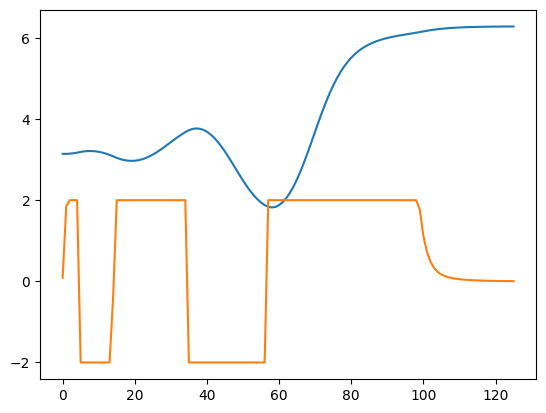

In [ ]:
# @title mpc oneshot = ilqr?
# print(xs.shape, us.shape)
n_batch, T, mpc_T = 1, 125, 125
q = torch.cat([goal_weights, ctrl_penalty]) # [1.0000, 1.0000, 0.1000, 0.0010]
px = -torch.sqrt(goal_weights)*goal_state # [-0., -1., -0.]
# p = torch.cat((px, torch.zeros(dx.n_ctrl)))
p = torch.cat((px, torch.ones(dx.n_ctrl)*0.))
Q = torch.diag(q).unsqueeze(0).unsqueeze(0).repeat(mpc_T, n_batch, 1, 1) # [mpc_T, n_batch, n_state+n_ctrl, n_state+n_ctrl]
p = p.unsqueeze(0).repeat(mpc_T, n_batch, 1) # [mpc_T, n_batch, n_state+n_ctrl] : [-0., -1., -0.,  0.]
if x.ndim == 1: x = x.unsqueeze(0).repeat(n_batch, 1)
if u==None: u = torch.rand(1,dx.n_ctrl)

xs, us, cost = MPC(
    dx.n_state, dx.n_ctrl, mpc_T, # state dim, action dim,
    u_init=u,
    u_lower=-2., u_upper=2., # +-0.5
    lqr_iter=5, # 50 num LQR iterations to perform
    # linesearch_decay=0.2, max_linesearch_iter=5,
    # grad_method=GradMethods.AUTO_DIFF,
    eps=1e-2,
)(x, QuadCost(Q, p), dx)


xs, us = locuslab_mpc(x, goal_state, dx)
#Plot theta and action trajectory
import matplotlib.pyplot as plt
theta = torch.arctan2(xs[:, 0], xs[:, 1]).detach()
theta = torch.where(theta < 0, 2*torch.pi+theta, theta)
plt.plot(theta)
plt.plot(us.detach())
plt.show()


In [ ]:
print(xs[-1])

tensor([-0.0026,  1.0000,  0.0075], grad_fn=<SelectBackward0>)


In [134]:
# @title cost func
# scipy.optimize.minimize, method="SLSQP"
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html

# all differentiable
# slew_rate_penalty λ: penalizes the slew rate λ/2 *||ut-ut+1||2 ^2

def bquad(x, Q): return x.unsqueeze(1).bmm(Q).bmm(x.unsqueeze(2)).squeeze(1).squeeze(1)
def bdot(x, y): return torch.bmm(x.unsqueeze(1), y.unsqueeze(2)).squeeze(1).squeeze(1)

def get_cost(T, u, cost, dynamics=None, x_init=None, x=None):
    assert x_init is not None or x is not None
    x = get_traj(T, u, x_init, dynamics)
    objs = []
    for t in range(T):
        xt = x[t]
        ut = u[t]
        xut = torch.cat((xt, ut), 1)
        obj = 0.5*bquad(xut, C[t]) + bdot(xut, c[t])
        # obj = cost(xut)
        objs.append(obj)
    total_obj = torch.sum(torch.stack(objs, dim=0), dim=0)
    return total_obj

dx = PendulumDx()#params, simple=True)

# tao = cat(x,u)
# C*tao^2 + c*tao

x = torch.tensor([0., -1., 0.]) # xinit # init state
u = torch.rand(1,dx.n_ctrl) # u_init # initial control
# goal_weights = torch.Tensor([1., 1., 0.1])
goal_weights = torch.Tensor([1., 1., .01])*1
goal_state = torch.Tensor([0., 1. ,0.])
ctrl_penalty = torch.Tensor([0.001])

def locuslab_mpc(x, goal_state, dx, u=None):
    # n_batch, T, mpc_T = 1, 125, 20 # 16, 100, 20 ; batch size, epochs, ? larger solves
    n_batch, T, mpc_T = 1, 125, 20
    q = torch.cat([goal_weights, ctrl_penalty]) # [1.0000, 1.0000, 0.1000, 0.0010]
    Q = torch.diag(q).unsqueeze(0).unsqueeze(0).repeat(mpc_T, n_batch, 1, 1) # [mpc_T, n_batch, n_state+n_ctrl, n_state+n_ctrl]
    px = -torch.sqrt(goal_weights)*goal_state # [-0., -1., -0.]
    p = torch.cat((px, torch.zeros(dx.n_ctrl))) # [-0., -1., -0., 0]
    p = p.unsqueeze(0).repeat(mpc_T, n_batch, 1) # [mpc_T, n_batch, n_state+n_ctrl] : [-0., -1., -0.,  0.]

# QuadCost(Q, p)

# 1/2 *tao@Q@tao.T? + tao@p.T?
# Q: diag [mpc_T, n_batch, tao, tao]
# p: [-0., -1., -0.,  0.] : [mpc_T, n_batch, tao]

# box-constrained control problem with a quadratic cost (defined by C and c) and non-linear dynamics (defined by f):
#         min_{tau={x,u}} sum_t 0.5 tau_t^T C_t tau_t + c_t^T tau_t
#                     s.t. x_{t+1} = f(x_t, u_t)
#             x_0 = x_init   ;   u_lower <= u <= u_upper



# RL like Q func + terminal state
# Sum Q(xt,ut) + cost(xT)

# tao = cat((x_t - xtarget_t) , u)
# quadratic cost func: taoT *Q *tao + p * tao

# terminal cost

# dut = ut - ut-1
# slew: dutT * S * dut

# Obstacle avoidance: l_obs = exp(-||xt - x_obs||^2 /σ)

# Energy cost: K *tao^2


# %timeit torch.einsum('btd,dd,btd->b', tao, Q, tao).mean() # 266 µs 225 229 #+ torch.einsum('btd,d->b', tao, R) # quad = tao @ Q @ tao.T# + R @ tao
# %timeit torch.trace(tao[0] @ Q @ tao[0].T) # 19.6 µs 19.6
# %timeit ((tao**2) @ Q.T).sum() # 19.6 µs 26.7
# %timeit ((tao**2) @ q.T).sum() # 19.1 µs 18.7


goal_weights = torch.Tensor([1., 1., 1.])*10
goal_state = torch.Tensor([0., 1. ,0.])
ctrl_penalty = torch.Tensor([0.00]) # .001?
def control_cost(lx, lu, goal_state, goal_weights=None, ctrl_penalty=None):
    if goal_weights is None: goal_weights = torch.ones(dx.n_state)
    if ctrl_penalty is None: ctrl_penalty = torch.ones(dx.n_ctrl)
    batch, T, _ = lx.shape
    # Q = torch.diag(torch.cat([goal_weights, ctrl_penalty], dim=-1))
    q = torch.cat([goal_weights, ctrl_penalty], dim=-1)
    R = torch.cat([torch.ones(dx.n_state), torch.ones(dx.n_ctrl)], dim=-1)
    # R = torch.tensor([-0., -1., -0.,  0.])
    P = 10. * torch.diag(torch.ones(dx.n_state))

    x_diff = lx - goal_state.unsqueeze(0)
    # print(x_diff.shape, lu.shape)
    tao = torch.cat((x_diff, lu), dim=-1)#.unsqueeze(0) # [batch, T, n_state+n_ctrl]
    # if lu.ndim == 2: lu = lu.unsqueeze(0)

    # time_weight = torch.linspace(1, 7**(.5), T, device=device)**2
    # time_weight = torch.ones(tao.shape[:2])
    g=T*95//100
    # print(T)
    # g=T-20
    time_weight = torch.cat([torch.zeros((g,)), torch.ones((T-g,))], dim=-1).unsqueeze(0).unsqueeze(-1)
    # time_weight = (1/.9)**torch.arange(tao.shape[-2]) -1
    # time_weight = .85**torch.arange(start=tao.shape[-2],end=0,step=-1)*10
    quad = (time_weight * (1.* (tao**2) @ q.unsqueeze(0).T + .0 * (tao @ R.unsqueeze(0).T))).sum()/batch
    # quad = (time_weight * (.5* (tao**2) @ q.T + 1. * (tao @ R.T))).mean()

    terminal_diff = lx[:,-1] - goal_state  # Terminal state # [batch, n_state]
    terminal_cost = torch.einsum('bd,dd,bd->b', terminal_diff, P, terminal_diff).mean()

    d2u = lu[:,2:] - 2 * lu[:,1:-1] + lu[:,:-2] # [batch, T-2, n_ctrl]
    # print(d2u.shape)
    jerk = 2. * (d2u**2).sum(-1).mean()

    du = lu[:,1:]-lu[:,:-1] # [batch, T-1, n_ctrl]
    # slew = 0.01 * torch.einsum('btu,btu->b', du, du).mean() # slew = 0.01 * du.T @ du
    slew = 0.01 * (du**2).sum()/batch * T/(T-2)
    # cost = slew + jerk + terminal_cost
    # cost = quad + slew + jerk# + terminal_cost
    cost = quad + jerk + terminal_cost
    # cost = quad + terminal_cost
    # cost = terminal_cost
    print(quad.data, slew.data, jerk.data, terminal_cost.data)
    return cost
b=4
T=10
# lx = torch.rand(T, dx.n_state)
# lu = torch.rand(T, dx.n_ctrl)
lx = torch.rand(b,T, dx.n_state)
lu = torch.rand(b,T, dx.n_ctrl)


cost = control_cost(lx, lu, goal_state, goal_weights, ctrl_penalty)
print(cost)


tensor(8.9022) tensor(0.0200) tensor(1.0376) tensor(8.9022)
tensor(18.8419)


In [ ]:
# @title test _|-
import torch
lx=torch.rand(2,7,3)
lu=torch.rand(2,7,1)
batch, T, _ = lx.shape

goal_weights = torch.Tensor([1., 1., 1.])*1
goal_state = torch.Tensor([0., 1. ,0.])
ctrl_penalty = torch.Tensor([0.00]) # .001?

q = 10*torch.cat([goal_weights, ctrl_penalty], dim=-1)
R = torch.cat([torch.ones(3), torch.ones(1)], dim=-1)
# R = torch.tensor([-0., -1., -0.,  0.])
P = 10. * torch.diag(torch.ones(3))

x_diff = lx - goal_state.unsqueeze(0)
# print(x_diff.shape, lu.shape)
tao = torch.cat((x_diff, lu), dim=-1)#.unsqueeze(0) # [batch, T, n_state+n_ctrl]
# if lu.ndim == 2: lu = lu.unsqueeze(0)

# time_weight = torch.linspace(1, 7**(.5), T, device=device)**2
# time_weight = torch.ones(tao.shape[:2])
# g=T*99//100
g=T-1
time_weight = torch.cat([torch.zeros((g,)), torch.ones((T-g,))], dim=-1).unsqueeze(0).unsqueeze(-1)
# quad = (time_weight * (1.* (tao**2) @ q.unsqueeze(0).T + .0 * (tao @ R.unsqueeze(0).T)))#.mean()
quad = (time_weight * (1.* (tao**2) @ q.unsqueeze(0).T + .0 * (tao @ R.unsqueeze(0).T))).sum()/batch

print(1.* (tao**2) @ q.unsqueeze(0).T)
print(time_weight * (1.* (tao**2) @ q.unsqueeze(0).T))

# print(quad.shape)
# print(time_weight)
terminal_diff = lx[:,-1] - goal_state  # Terminal state # [batch, n_state]
# terminal_cost = torch.einsum('bd,dd,bd->b', terminal_diff, P, terminal_diff).mean()
# terminal_cost = torch.einsum('bd,dd,bd->b', terminal_diff, P, terminal_diff).sum()
# print(terminal_cost.data)
# terminal_cost = torch.trace(terminal_diff@ P@ terminal_diff.T)/batch
# print(terminal_cost.data)
terminal_cost = ((terminal_diff**2) @ P.T).sum()/batch
print(terminal_cost.data)

# %timeit torch.einsum('btd,dd,btd->b', tao, Q, tao).mean() # 266 µs 225 229 #+ torch.einsum('btd,d->b', tao, R) # quad = tao @ Q @ tao.T# + R @ tao
# %timeit torch.trace(tao[0] @ Q @ tao[0].T) # 19.6 µs 19.6
# %timeit ((tao**2) @ Q.T).sum() # 19.6 µs 26.7
# %timeit ((tao**2) @ q.T).sum() # 19.1 µs 18.7


print(quad.data, terminal_cost.data)



print(terminal_diff)
time_weight = 1*torch.cat([torch.zeros((g,)), torch.ones((T-g,))], dim=-1).unsqueeze(0).unsqueeze(-1)

# print(tao[:,-1])
# print(time_weight*tao)
print(time_weight * (1.* (tao**2) @ q.unsqueeze(0).T))
# quad = (time_weight * (1.* (tao**2) @ q.unsqueeze(0).T + 0.0 * (tao @ R.unsqueeze(0).T))).mean()
quad = (time_weight * (1.* (tao**2) @ q.unsqueeze(0).T + 0.0 * (tao @ R.unsqueeze(0).T))).sum()/batch

# print(P)
terminal_cost = torch.einsum('bd,dd,bd->b', terminal_diff, P, terminal_diff).mean()#.sum()/batch
print(terminal_cost.data)
terminal_cost = torch.trace(terminal_diff@ P@ terminal_diff.T)/batch
print(terminal_cost.data)
terminal_cost = ((terminal_diff**2) @ P.T).sum()/batch
print(terminal_cost.data)
# print(((terminal_diff**2) @ P.T).shape)
print(quad.data, terminal_cost.data)



In [ ]:
# @title me_mpc
import torch
import torch.nn as nn
device = "cuda" if torch.cuda.is_available() else "cpu"

dx = PendulumDx()#params, simple=True)

torch.manual_seed(0)
x = torch.tensor([0., -1., 0.]) # xinit # init state
u = torch.rand(1,dx.n_ctrl) # u_init # initial control
goal_weights = torch.Tensor([1., 1., 1.])*1
goal_state = torch.Tensor([0., 1. ,0.])
ctrl_penalty = torch.Tensor([0.001])


def locuslab_mpc(x, goal_state, dx, u=None):
    # n_batch, T, mpc_T = 1, 125, 20 # 16, 100, 20 ; batch size, epochs, mpc window size? larger solves
    n_batch, T, mpc_T = 1, 125, 20
    q = torch.cat([goal_weights, ctrl_penalty]) # [1.0000, 1.0000, 0.1000, 0.0010]
    px = -torch.sqrt(goal_weights)*goal_state # [-0., -1., -0.]
    # p = torch.cat((px, torch.zeros(dx.n_ctrl)))
    p = torch.cat((px, torch.ones(dx.n_ctrl)*0.))
    Q = torch.diag(q).unsqueeze(0).unsqueeze(0).repeat(mpc_T, n_batch, 1, 1) # [mpc_T, n_batch, n_state+n_ctrl, n_state+n_ctrl]
    p = p.unsqueeze(0).repeat(mpc_T, n_batch, 1) # [mpc_T, n_batch, n_state+n_ctrl] : [-0., -1., -0.,  0.]
    if x.ndim == 1: x = x.unsqueeze(0).repeat(n_batch, 1)
    if u==None: u = torch.rand(1,dx.n_ctrl)
    xs = x
    us = u
    # print('u1',u)

    for t in tqdm(range(T)):
        # x1, u1, cost = MPC(
        #     dx.n_state, dx.n_ctrl, mpc_T, # state dim, action dim,
        #     u_init=u,
        #     u_lower=-2., u_upper=2., # +-0.5
        #     lqr_iter=5, # 50 num LQR iterations to perform
        # )(x, QuadCost(Q, p), dx)
        next_action = u1[0]
        u = torch.cat((u1[1:], torch.randn(1, n_batch, dx.n_ctrl)), dim=0) # zeros randn
        x = dx(x, next_action)





x = torch.tensor([0., -1., 0.])

def rnn_it(x,u,dx):
    lx = x.unsqueeze(1) # [batch,1,n_state]
    batch, n_state = x.shape
    lx = torch.empty((batch,0,n_state),device=device)
    T = u.shape[1]
    for t in range(T):
        x = dx(x, u[:,t])
        lx = torch.cat([lx, x.unsqueeze(1)], dim=1) # [batch,T,n_state]
    return lx


batch = 1
# T=128
x = torch.tensor([0., -1., 0.]).unsqueeze(0).repeat(batch, 1)
# lu = nn.Parameter(torch.rand((batch, T, dx.n_ctrl),device=device))

# def MPCoptim(x,goal_state,dx,lu=None,T=20, optim=None,optim_steps=5, u_lower=-2., u_upper=2.):
def MPCoptim(x,goal_state,dx,lu, optim,T=20,optim_steps=5, u_lower=-2., u_upper=2.):
    for i in range(optim_steps):
        lx = rnn_it(x,lu,dx)
        # print(lx.shape, lu.shape)
        # with torch.no_grad(): lu += torch.randn_like(lu)*0.1 # 0.25?
        cost = control_cost(lx, lu, goal_state, goal_weights, ctrl_penalty)
        # print(cost)
        cost.backward()
        optim.step()
        optim.zero_grad()
        with torch.no_grad(): lu.clamp_(min=u_lower, max=u_upper)

        # print("####{}####".format(i))
        # xs, us = lx[0], lu[0]
        # theta = torch.arctan2(xs[:, 0], xs[:, 1]).detach()
        # theta = torch.where(theta < 0, 2*torch.pi+theta, theta)
        # plt.plot(theta)
        # plt.plot(us.detach())
        # plt.show()

    # print(lx, lu, cost)
    return lx, lu, cost
    # return lx.detach(), lu.detach(), cost.detach()


from tqdm import tqdm
def me_mpc(x, goal_state, dx, lu=None):
    n_batch, T, mpc_T = 1, 125, 50
    xs, us = torch.empty(n_batch,0, dx.n_state), torch.empty(n_batch,0, dx.n_ctrl)
    if lu==None: lu = torch.rand((n_batch, T, dx.n_ctrl),device=device)
    # if lu==None: lu = torch.rand((batch, T, dx.n_ctrl),device=device)
    lu = nn.Parameter(lu)
    optim = torch.optim.AdamW([lu], 1e-1, (0.9, 0.999)) # 1e-1
    # optim = torch.optim.AdamW([lu], 1e-1, (0.1, 0.5)) #
    # optim = torch.optim.SGD([lu], 1e-1, momentum=0.5)
    for t in tqdm(range(T-mpc_T+1)):
        # print(t)
        # print(l[t:t+mpc_T])
        _, lut, cost = MPCoptim(x,goal_state,dx,lu=lu[:,t:t+mpc_T],optim=optim)
        next_action = lut[:,0].detach()
        # print(lu[:,1:].shape)
        # print(next_action.shape)
        # print(x.shape)
        # lu = torch.cat((lu[:,1:], torch.randn(n_batch, 1, dx.n_ctrl)), dim=1) # zeros randn
        x = dx(x, next_action)
        us = torch.cat([us,next_action.unsqueeze(1)], dim=1) # [batch,T,n_ctrl]
        xs = torch.cat([xs,x.unsqueeze(1)], dim=1)


        print("####{}####".format(t))
        lxs, lus = lx[0], lu[0]
        theta = torch.arctan2(lxs[:, 0], lxs[:, 1]).detach()
        theta = torch.where(theta < 0, 2*torch.pi+theta, theta)
        plt.plot(theta)
        plt.plot(lus.detach())
        plt.show()

        # break
    return xs, us

# lx, lu, _ = MPCoptim(x,goal_state,dx,lu=None,T=20, batch=1,optim_steps=50, u_lower=-2., u_upper=2.)
lx, lu = me_mpc(x, goal_state, dx, lu=None)
xs, us = lx[0], lu[0]
# xs, us = locuslab_mpc(x, goal_state, dx)
#Plot theta and action trajectory
import matplotlib.pyplot as plt
theta = torch.arctan2(xs[:, 0], xs[:, 1]).detach()
theta = torch.where(theta < 0, 2*torch.pi+theta, theta)
plt.plot(theta)
plt.plot(us.detach())
plt.show()



tensor(20.0023) tensor(0.4454) tensor(2.4755) tensor(40.3513)
####0####


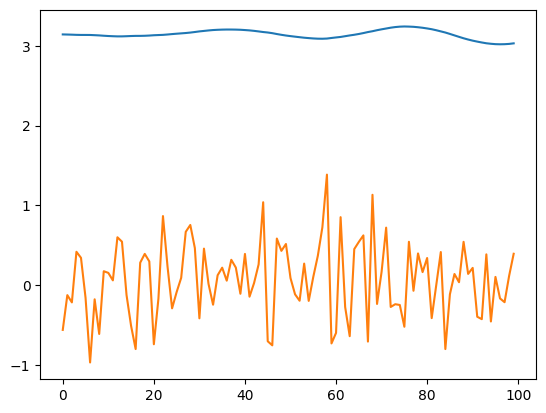

tensor(5.0554) tensor(1.2275) tensor(7.4732) tensor(20.9547)
####1####


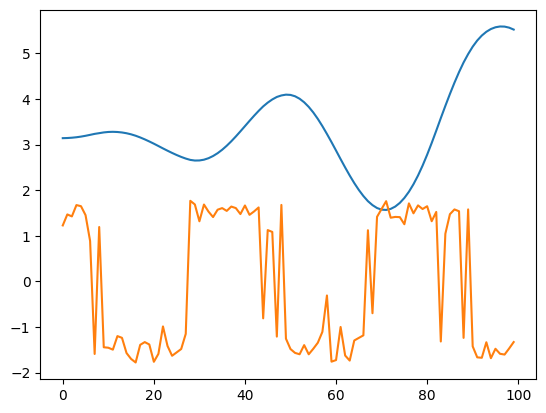

tensor(50.0481) tensor(0.7949) tensor(4.3248) tensor(69.0176)
####2####


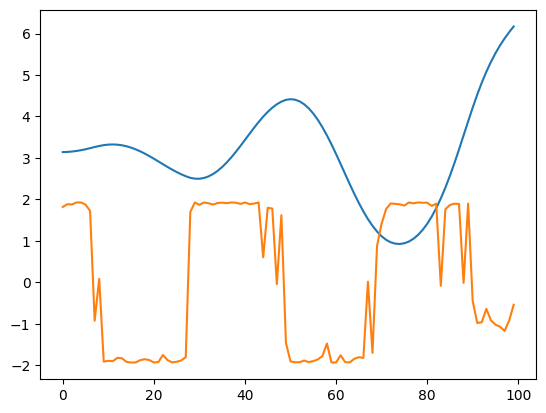

tensor(45.5360) tensor(0.8770) tensor(4.7663) tensor(51.7248)
####3####


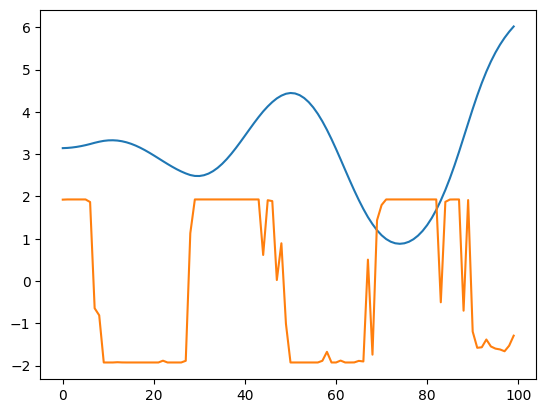

tensor(33.8956) tensor(1.2114) tensor(6.9190) tensor(35.3805)
####4####


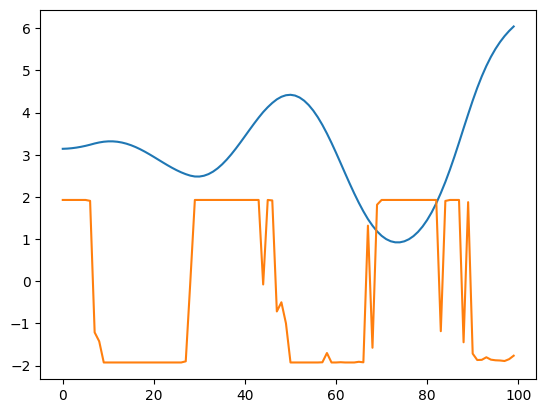

tensor(27.4124) tensor(1.5085) tensor(8.6387) tensor(27.8693)
####5####


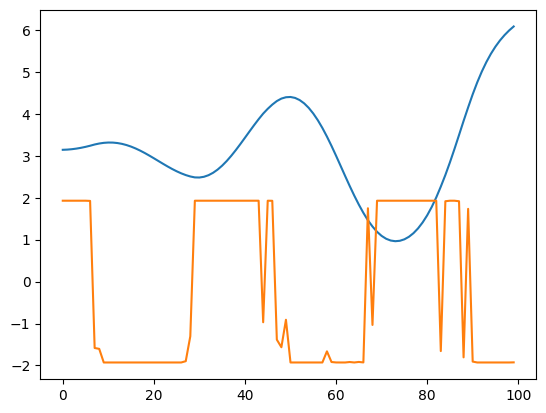

tensor(22.9945) tensor(1.5582) tensor(8.6659) tensor(22.8827)
####6####


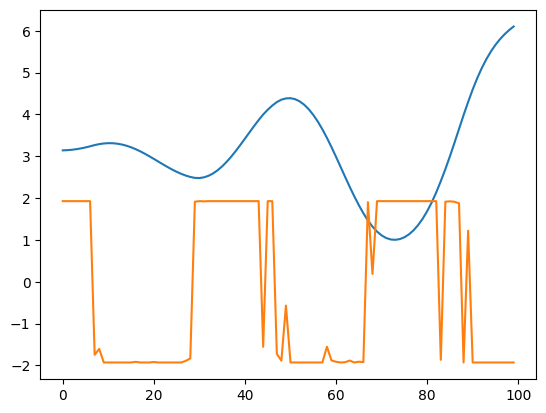

tensor(18.4530) tensor(1.4867) tensor(7.8697) tensor(16.6042)
####7####


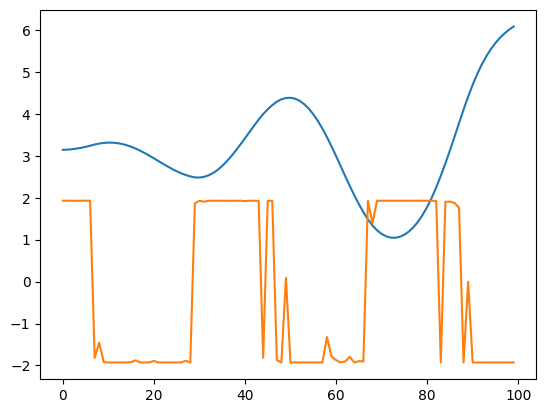

tensor(13.5150) tensor(1.4545) tensor(7.4553) tensor(9.6473)
####8####


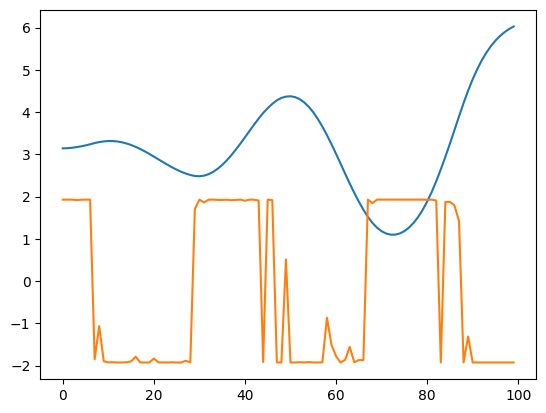

tensor(7.6003) tensor(1.4115) tensor(7.1690) tensor(3.0200)
####9####


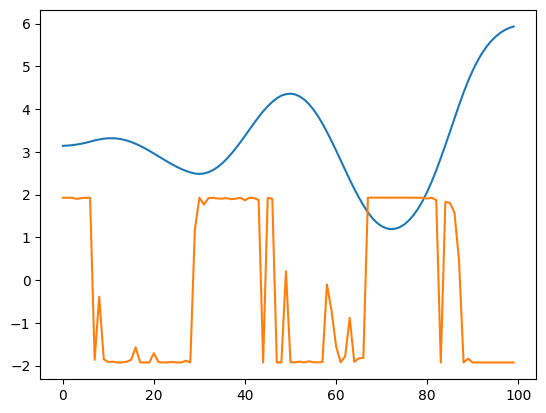

tensor(3.3060) tensor(1.4571) tensor(7.3043) tensor(5.5334)
####10####


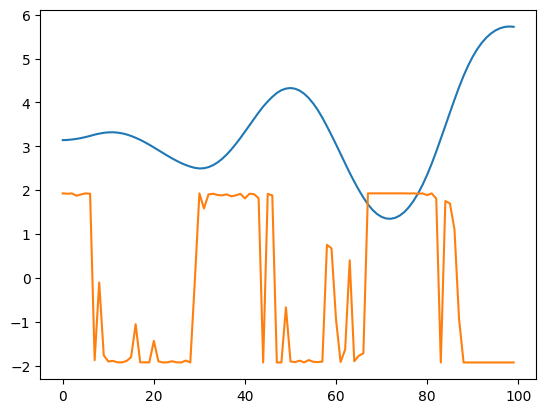

tensor(3.6764) tensor(1.4592) tensor(7.0991) tensor(13.0399)
####11####


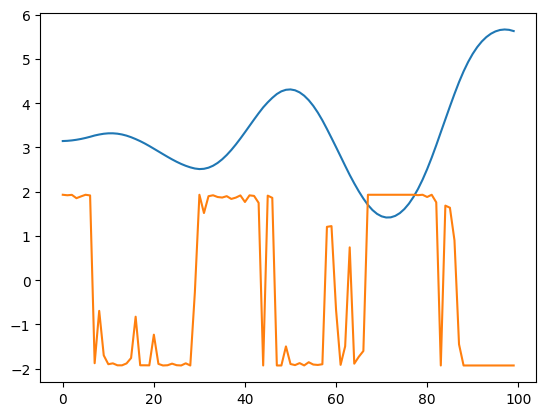

tensor(2.9573) tensor(1.4063) tensor(6.6242) tensor(6.5567)
####12####


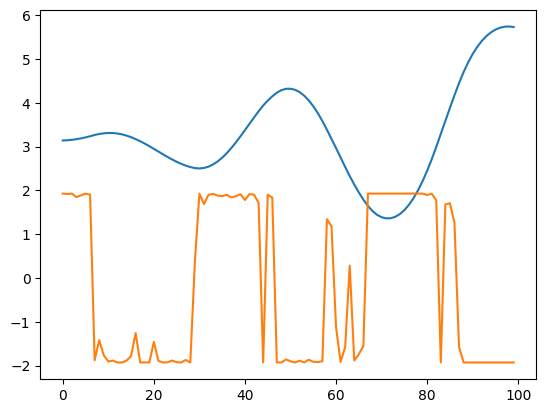

tensor(3.4736) tensor(1.3926) tensor(6.4894) tensor(2.1911)
####13####


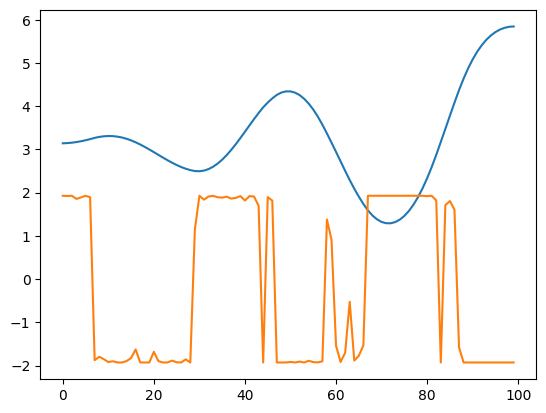

tensor(4.5717) tensor(1.3917) tensor(6.4896) tensor(1.5064)
####14####


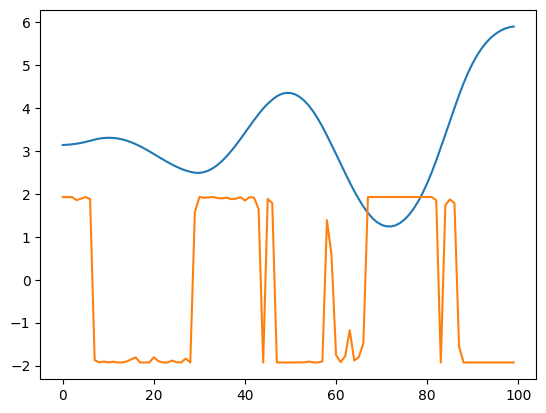

tensor(5.1685) tensor(1.3802) tensor(6.4222) tensor(1.6312)
####15####


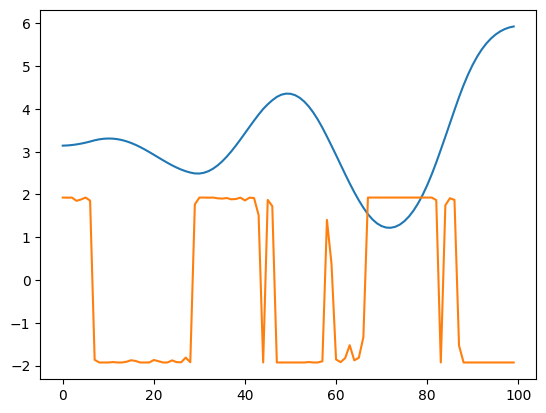

tensor(5.0224) tensor(1.3481) tensor(6.1805) tensor(1.5668)
####16####


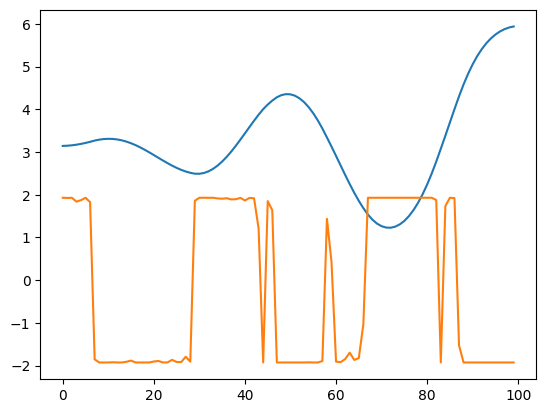

tensor(4.1864) tensor(1.2986) tensor(5.7628) tensor(1.2893)
####17####


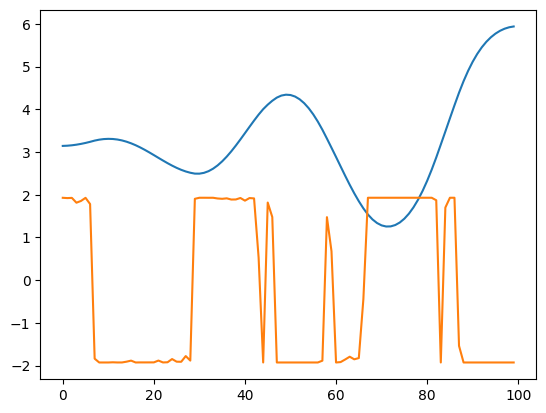

tensor(3.1229) tensor(1.2770) tensor(5.4654) tensor(1.2826)
####18####


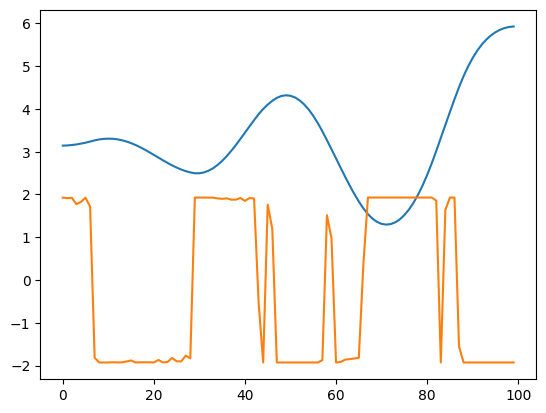

tensor(2.4305) tensor(1.2852) tensor(5.4242) tensor(1.7279)
####19####


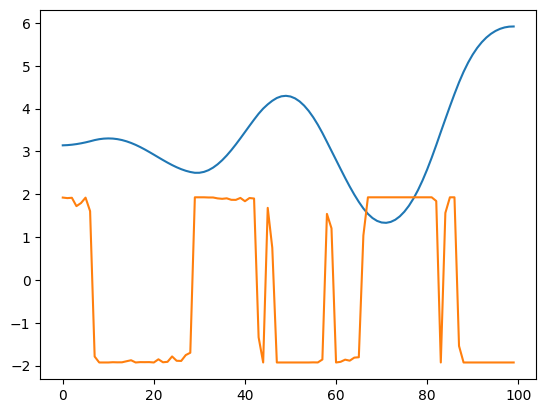

tensor(2.0878) tensor(1.2558) tensor(5.2704) tensor(1.9672)
####20####


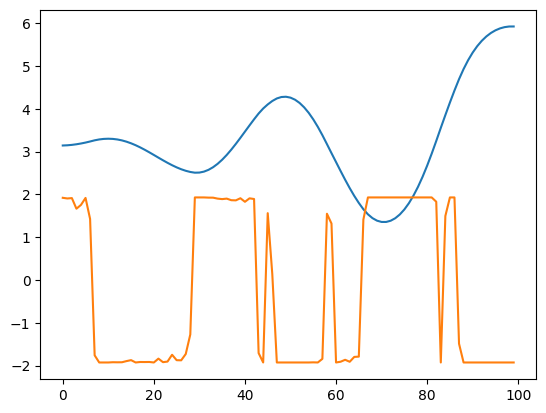

tensor(1.9130) tensor(1.1885) tensor(4.9437) tensor(1.4199)
####21####


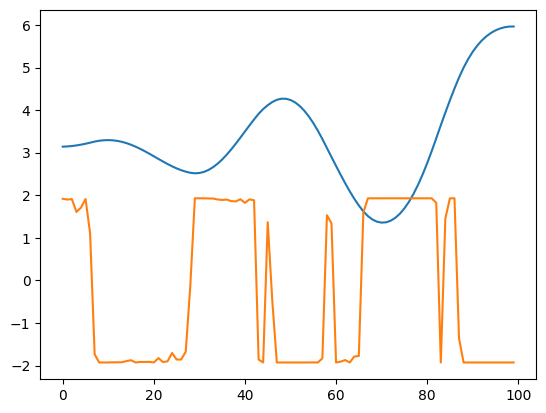

tensor(1.9430) tensor(1.1523) tensor(4.8103) tensor(0.6430)
####22####


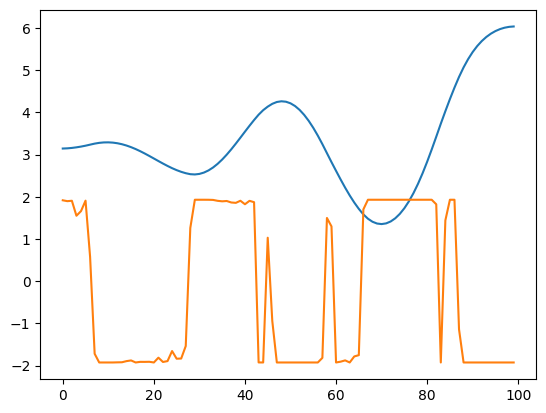

tensor(2.0737) tensor(1.0897) tensor(4.5106) tensor(0.4232)
####23####


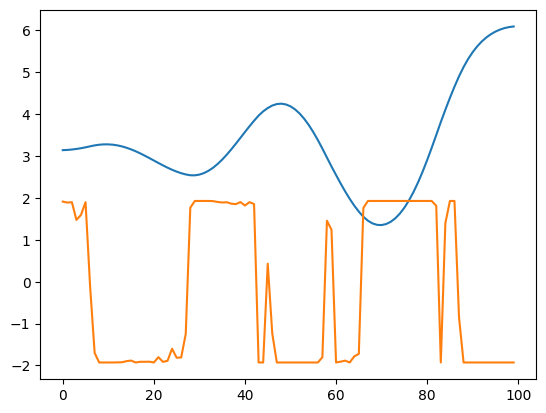

tensor(2.1228) tensor(1.0111) tensor(4.0801) tensor(0.4653)
####24####


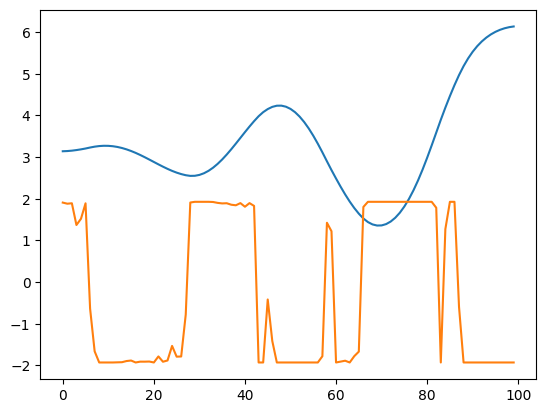

tensor(1.7892) tensor(0.9584) tensor(3.7514) tensor(0.3231)
####25####


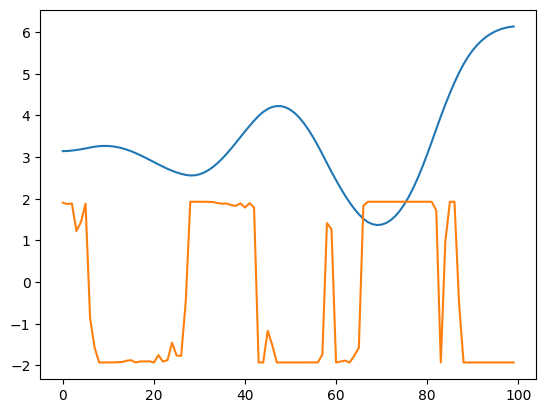

tensor(1.2414) tensor(0.9209) tensor(3.4616) tensor(0.5304)
####26####


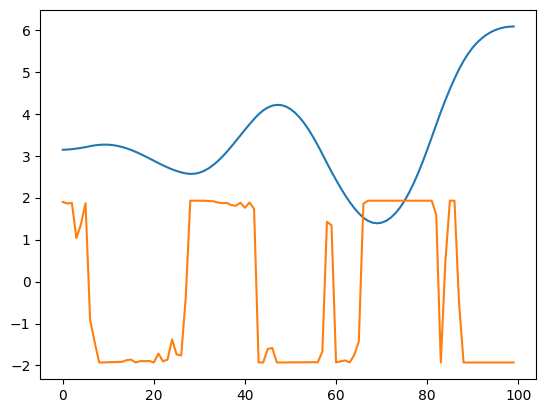

tensor(1.0251) tensor(0.8844) tensor(3.1792) tensor(1.2060)
####27####


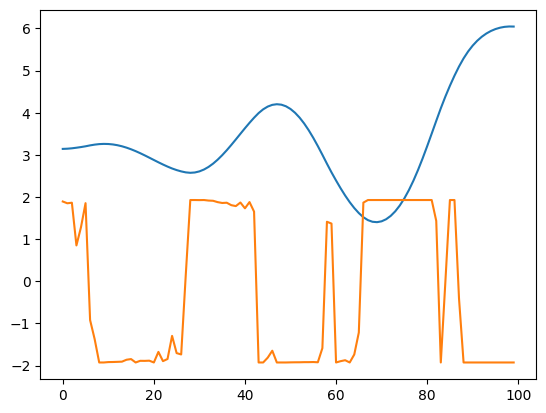

tensor(1.0291) tensor(0.8722) tensor(3.0996) tensor(0.5698)
####28####


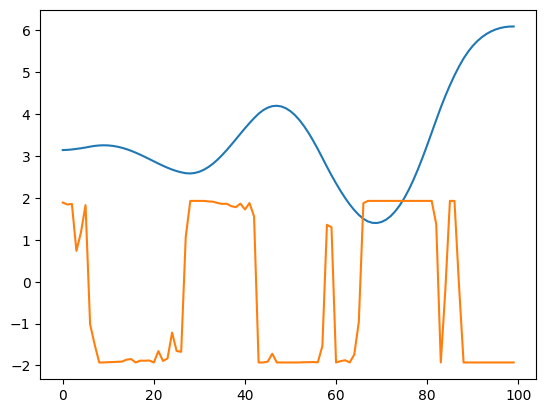

tensor(1.2401) tensor(0.8608) tensor(3.0576) tensor(0.1797)
####29####


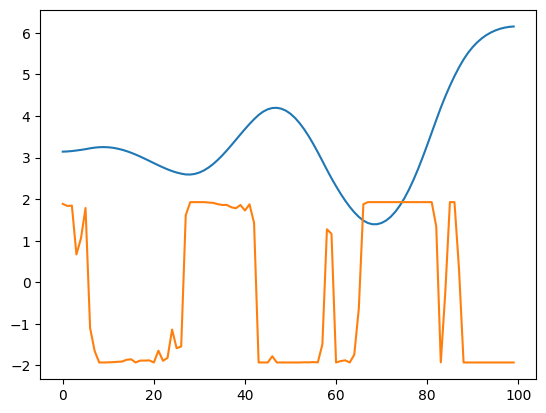

tensor(1.2155) tensor(0.8189) tensor(2.8087) tensor(0.1596)
####30####


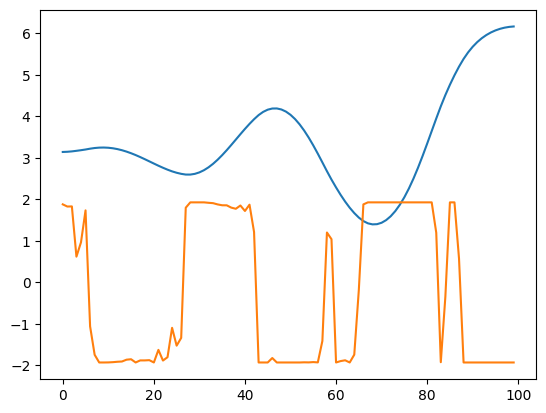

tensor(0.9066) tensor(0.7584) tensor(2.4182) tensor(0.3515)
####31####


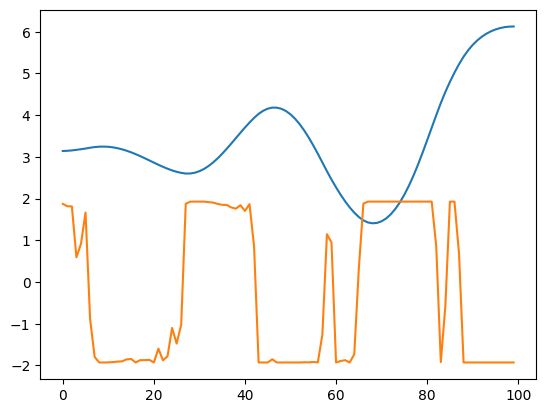

tensor(0.7999) tensor(0.6960) tensor(2.0584) tensor(0.5014)
####32####


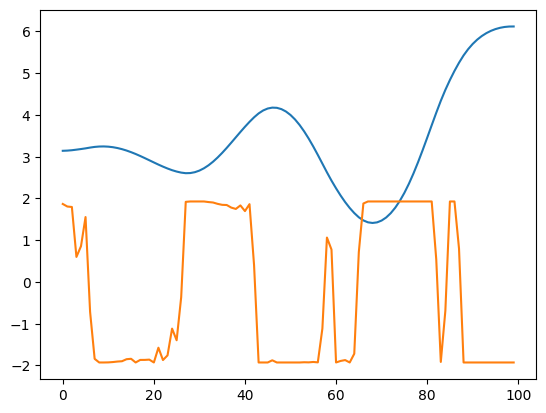

tensor(1.0415) tensor(0.6541) tensor(1.8816) tensor(0.1093)
####33####


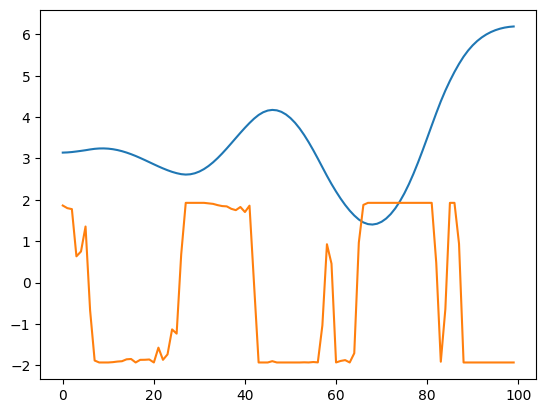

tensor(0.9003) tensor(0.6322) tensor(1.7655) tensor(0.1096)
####34####


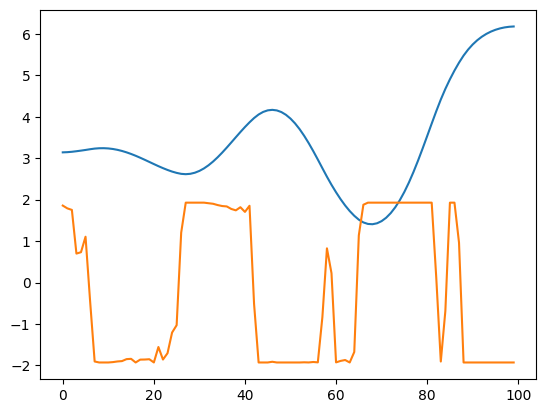

tensor(0.6812) tensor(0.6224) tensor(1.7107) tensor(0.4429)
####35####


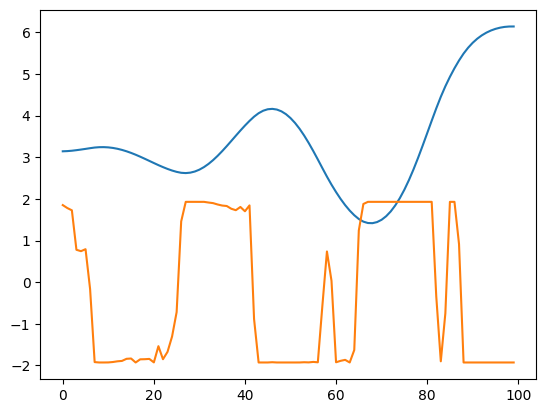

tensor(0.9660) tensor(0.5975) tensor(1.6261) tensor(0.0927)
####36####


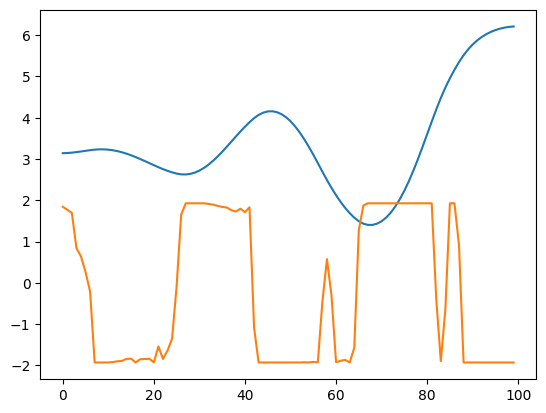

tensor(0.7730) tensor(0.6058) tensor(1.6844) tensor(0.0927)
####37####


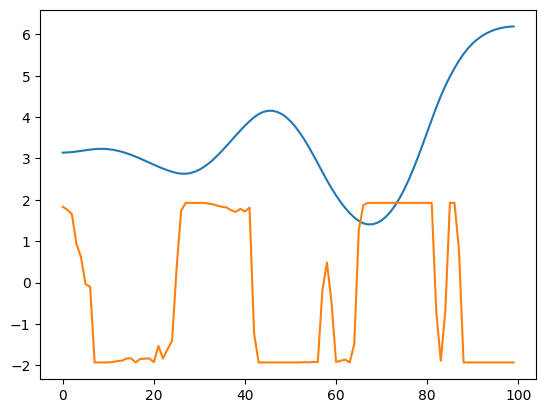

tensor(0.6113) tensor(0.6159) tensor(1.7454) tensor(0.3294)
####38####


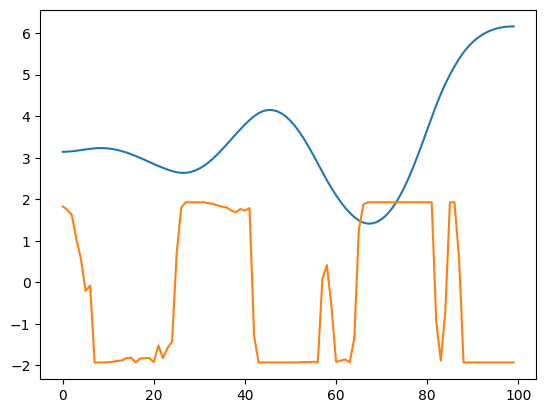

tensor(0.9000) tensor(0.5936) tensor(1.6365) tensor(0.0869)
####39####


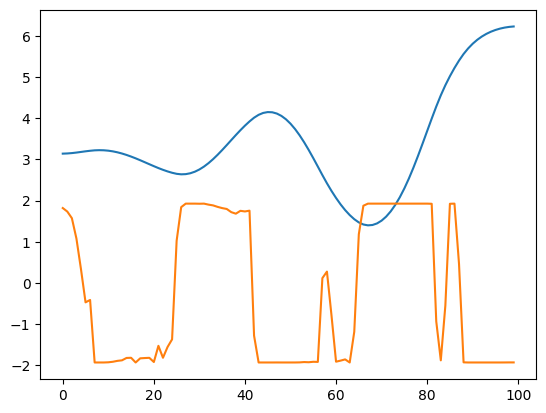

tensor(0.6120) tensor(0.5841) tensor(1.5751) tensor(0.1684)
####40####


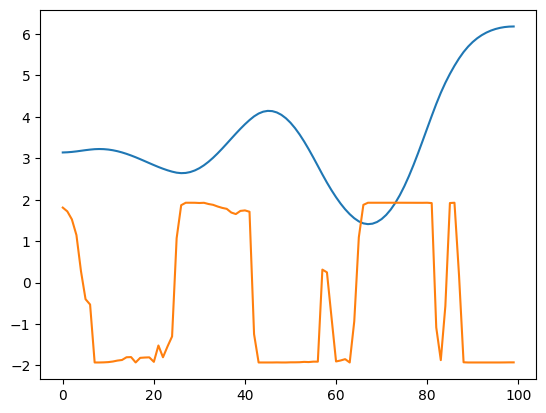

tensor(0.6036) tensor(0.5593) tensor(1.4481) tensor(0.1334)
####41####


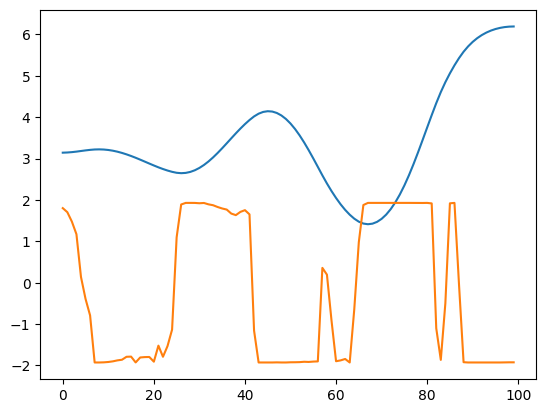

tensor(0.7895) tensor(0.5279) tensor(1.3074) tensor(0.0585)
####42####


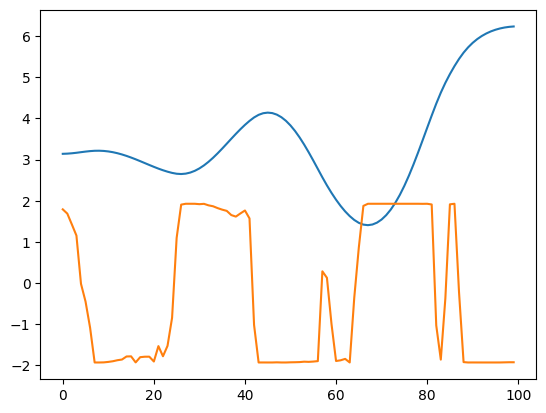

tensor(0.4793) tensor(0.5216) tensor(1.3017) tensor(0.4072)
####43####


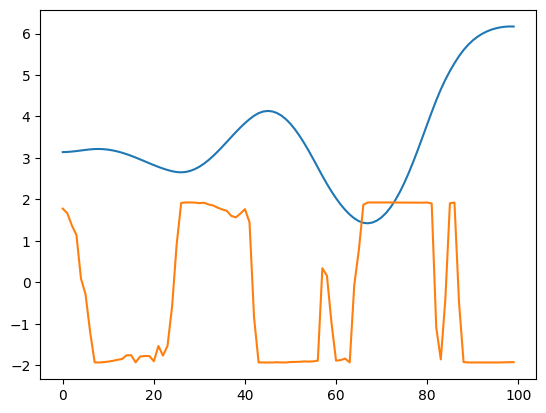

tensor(0.9030) tensor(0.4908) tensor(1.1914) tensor(0.1737)
####44####


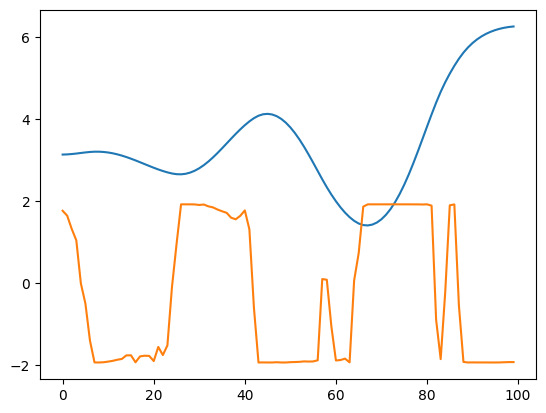

tensor(0.4378) tensor(0.5009) tensor(1.2682) tensor(1.0199)
####45####


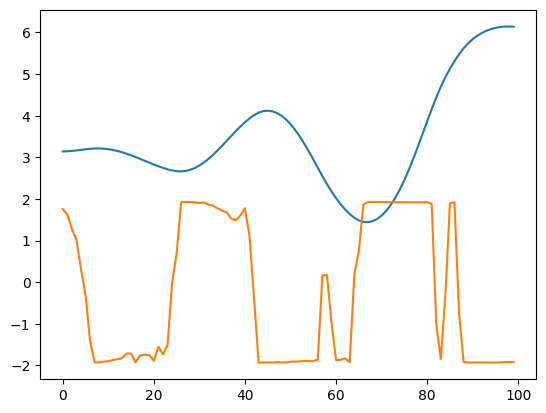

tensor(1.6837) tensor(0.4625) tensor(1.1152) tensor(1.4562)
####46####


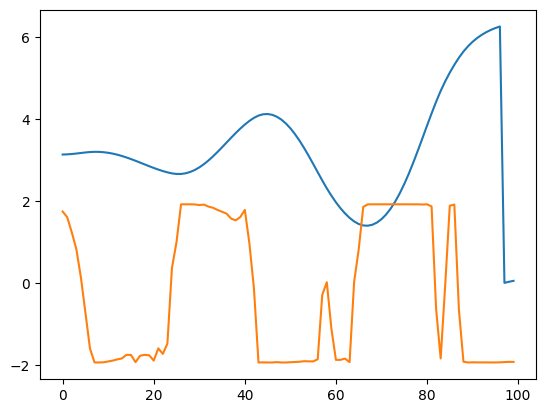

tensor(1.0072) tensor(0.4979) tensor(1.2665) tensor(4.9481)
####47####


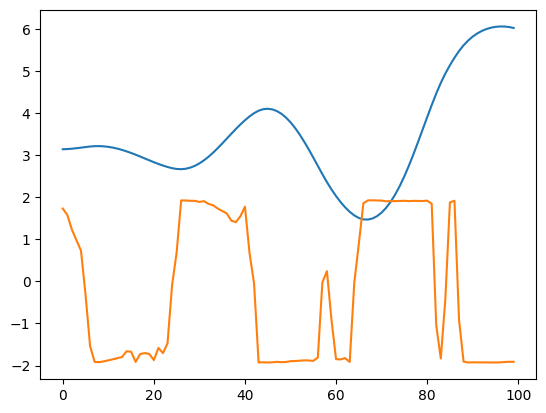

tensor(3.1823) tensor(0.4532) tensor(1.0619) tensor(4.5267)
####48####


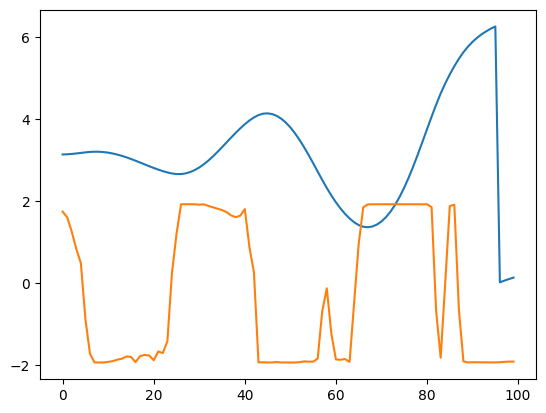

tensor(0.8743) tensor(0.4934) tensor(1.2082) tensor(0.0958)
####49####


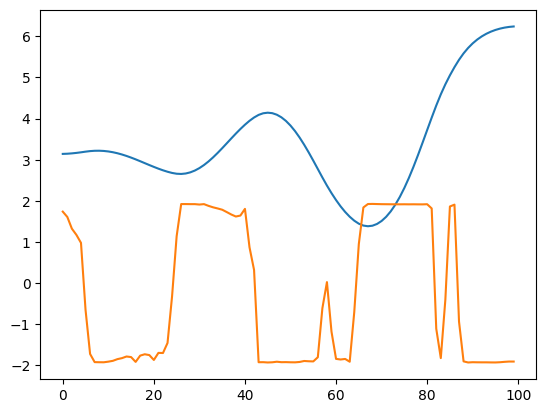

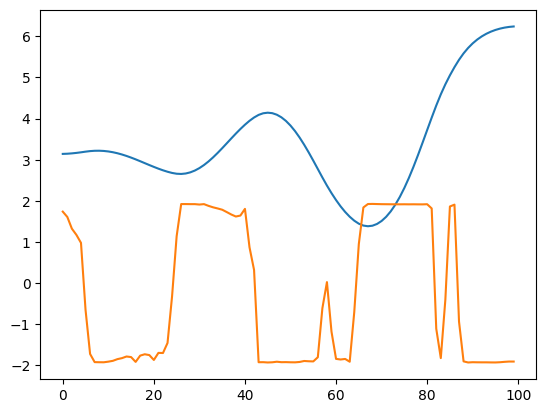

In [135]:
# @title me_mpc save
import torch
import torch.nn as nn
import torch.nn.functional as F
device = "cuda" if torch.cuda.is_available() else "cpu"
# torch.backends.cuda.matmul.allow_tf32 = True
# torch.backends.cudnn.allow_tf32 = True
# scaler = torch.cuda.amp.GradScaler()

dx = PendulumDx()

torch.manual_seed(0)
x = torch.tensor([0., -1., 0.]) # xinit # init state
u = torch.rand(1,dx.n_ctrl) # u_init # initial control
goal_weights = torch.Tensor([1., 1., 1.])*1 # [1., 1., 0.1]
goal_state = torch.Tensor([0., 1. ,0.])
ctrl_penalty = torch.Tensor([0.001])


def rnn_it(x,u,dx):
    lx = x.unsqueeze(1) # [batch,1,n_state]
    batch, n_state = x.shape
    lx = torch.empty((batch,0,n_state),device=device)
    T = u.shape[1]
    for t in range(T):
        x = dx(x, u[:,t])
        lx = torch.cat([lx, x.unsqueeze(1)], dim=1) # [batch,T,n_state]
    return lx


batch = 1
# T=128
x = torch.tensor([0., -1., 0.]).unsqueeze(0).repeat(batch, 1)
# lu = nn.Parameter(torch.rand((batch, T, dx.n_ctrl),device=device))

# def MPCoptim(x,goal_state,dx,lu=None,T=20, batch=1,optim_steps=20, u_lower=-2., u_upper=2.):
#     if lu==None: lu = torch.randn((batch, T, dx.n_ctrl),device=device)*2
#     lu = nn.Parameter(lu)
#     optim = torch.optim.AdamW([lu], 1e-0, (0.9, 0.999)) # 1e-1
#     # optim = torch.optim.AdamW([lu], 1e-1, (0.1, 0.5)) #
#     # optim = torch.optim.SGD([lu], 1e-1, momentum=0.5)

#     for i in range(optim_steps):
#         lu = (F.tanh(lu)+1-u_lower)*(u_upper-u_lower)/2
#         lx = rnn_it(x,lu,dx)
#         # print(lx.shape, lu.shape)
#         # with torch.no_grad(): lu += torch.randn_like(lu)*0.1 # 0.25?
#         cost = control_cost(lx, lu, goal_state, goal_weights, ctrl_penalty)
#         # print(cost)
#         cost.backward()
#         optim.step()
#         optim.zero_grad()
#         # with torch.no_grad(): lu.clamp_(min=u_lower, max=u_upper)

#         print("####{}####".format(i))
#         xs, us = lx[0], lu[0]
#         theta = torch.arctan2(xs[:, 0], xs[:, 1]).detach()
#         theta = torch.where(theta < 0, 2*torch.pi+theta, theta)
#         plt.plot(theta)
#         plt.plot(us.detach())
#         plt.show()

#     return lx, lu, cost
#     # return lx.detach(), lu.detach(), cost.detach()


def MPCoptim(x,goal_state,dx,lu=None,T=20, batch=1,optim_steps=20, u_lower=-2., u_upper=2.):
    if lu==None: lu = torch.randn((batch, T, dx.n_ctrl),device=device)*.25
    lu = nn.Parameter(lu)
    optim = torch.optim.AdamW([lu], 1e-0, (0.9, 0.999)) # 1e-1
    # optim = torch.optim.SGD([lu], 1e1, momentum=0.) # 1e1
    for i in range(optim_steps):
        tlu = (F.tanh(lu)+1)/2*(u_upper-u_lower)+u_lower
        # tlu = u_lower + (u_upper - u_lower) * torch.sigmoid(lu)

        # tlu = F.tanh(lu)*2
        lx = rnn_it(x,tlu,dx)
        # print(lx.shape, lu.shape)
        # with torch.no_grad(): lu += torch.randn_like(lu)*0.1 # 0.25?
        cost = control_cost(lx, tlu, goal_state, goal_weights, ctrl_penalty)
        # print(cost)
        cost.backward()
        optim.step()
        optim.zero_grad()
        # with torch.no_grad(): lu.clamp_(min=u_lower, max=u_upper)
        with torch.no_grad(): lu.clamp_(min=-2, max=2)
        # with torch.no_grad(): lu.clamp_(min=-4, max=4)

        print("####{}####".format(i))
        xs, us = lx[0], tlu[0]
        theta = torch.arctan2(xs[:, 0], xs[:, 1]).detach()
        theta = torch.where(theta < 0, 2*torch.pi+theta, theta)
        plt.plot(theta)
        plt.plot(us.detach())
        plt.show()

    return lx, tlu, cost


# from tqdm import tqdm
# def me_mpc(x, goal_state, dx, u=None):
#     n_batch, T, mpc_T = 1, 125, 1
#     # xs, us = goal_state, torch.zeros(1, dx.n_ctrl)
#     xs, us = torch.empty(n_batch,0, dx.n_state), torch.empty(n_batch,0, dx.n_ctrl)
#     for t in tqdm(range(T)):
#         _, lu, cost = MPCoptim(x,goal_state,dx,lu=None,)
#         next_action = lu[:,0].detach()
#         # print(lu[:,1:].shape)
#         # print(next_action.shape)
#         # print(x.shape)
#         lu = torch.cat((lu[:,1:], torch.randn(n_batch, 1, dx.n_ctrl)), dim=1) # zeros randn
#         x = dx(x, next_action)
#         us = torch.cat([us,next_action.unsqueeze(1)], dim=1) # [batch,T,n_ctrl]
#         xs = torch.cat([xs,x.unsqueeze(1)], dim=1)
#         # break
#     return xs, us

# lx, lu, _ = MPCoptim(x,goal_state,dx,lu=lu,T=100, batch=1,optim_steps=50, u_lower=-2., u_upper=2.)
lx, lu, _ = MPCoptim(x,goal_state,dx,lu=None,T=100, batch=1,optim_steps=50, u_lower=-2., u_upper=2.)
# lx, lu = me_mpc(x, goal_state, dx, u=None)
xs, us = lx[0], lu[0]
# xs, us = locuslab_mpc(x, goal_state, dx)
#Plot theta and action trajectory
import matplotlib.pyplot as plt
theta = torch.arctan2(xs[:, 0], xs[:, 1]).detach()
theta = torch.where(theta < 0, 2*torch.pi+theta, theta)
plt.plot(theta)
plt.plot(us.detach())
plt.show()



In [93]:
# lu = torch.tensor(4)
lu = torch.rand(4,3)
# print(F.tanh(lu))
print(F.sigmoid(lu))


tensor([[0.6277, 0.6394, 0.6499],
        [0.6673, 0.6295, 0.5637],
        [0.6763, 0.5051, 0.5507],
        [0.5926, 0.5638, 0.5806]])


In [136]:
 # print(xs[-1])
print(xs[-5:])


tensor([[-0.1283,  0.9917,  0.6453],
        [-0.0963,  0.9954,  0.4851],
        [-0.0721,  0.9974,  0.3413],
        [-0.0551,  0.9985,  0.2100],
        [-0.0446,  0.9990,  0.0871]], grad_fn=<SliceBackward0>)


In [ ]:
# @title Cross-entropy method

import torch

def objective_function(x):
    return -torch.sum((x - 2.0)**2, dim=-1)  # Maximum at x = 2

def cross_entropy_method(obj_func, n_iterations=50, population_size=100, elite_frac=0.2, dim=2):
    mean = torch.zeros(dim)
    std = torch.ones(dim)

    n_elite = int(population_size * elite_frac)

    for iteration in range(n_iterations):
        # Sample from the current distribution
        population = torch.normal(mean, std.expand(population_size, dim))

        # Evaluate the population
        scores = obj_func(population)

        # Select the elite samples
        elite_indices = scores.argsort(descending=True)[:n_elite]
        elite_samples = population[elite_indices]

        # Update the distribution parameters
        mean = elite_samples.mean(dim=0)
        std = elite_samples.std(dim=0)

        # Print progress
        print(f"Iteration {iteration+1}: Best score = {scores[elite_indices[0]]}")

    return mean, std

# Run the Cross-Entropy Method
best_mean, best_std = cross_entropy_method(objective_function)

print(f"\nOptimised Mean: {best_mean}")
print(f"Optimised Std: {best_std}")



In [ ]:
batch, T, n_ctrl = 2,5,1
# lx = torch.rand((batch,3,),device=device)
x = torch.tensor([0., -1., 0.]).unsqueeze(0).repeat(batch, 1)
goal_state = torch.Tensor([0., 1. ,0.])

lu = torch.rand((batch, T, n_ctrl),device=device)
lu = nn.Parameter(lu)
# optim = torch.optim.AdamW([lu], 1e-1, (0.9, 0.999)) # 1e-1
optim = torch.optim.SGD([lu], 1e-1, momentum=0.1) # 1e-1
print(lu)
# print(optim.state_dict())

for i in range(3):
    # lx = rnn_it(x,lu,dx)
    lx = rnn_it(x,lu[:,:2],dx)
    cost = control_cost(lx, lu[:,:2], goal_state, goal_weights, ctrl_penalty)
    cost.backward()
    optim.step()
    optim.zero_grad()

print(lu)
# print(optim.state_dict())
# print(optim.state_dict()['state'][0].items())
# for i,v in optim.state_dict()['state'][0].items():
#     print(i,v)
# exp_avg exp_avg_sq


Parameter containing:
tensor([[[0.7403],
         [0.6766],
         [0.3798],
         [0.3948],
         [0.0880]],

        [[0.7709],
         [0.8970],
         [0.8421],
         [0.1473],
         [0.5223]]], requires_grad=True)
Parameter containing:
tensor([[[0.7160],
         [0.6528],
         [0.3798],
         [0.3948],
         [0.0880]],

        [[0.7708],
         [0.8968],
         [0.8421],
         [0.1473],
         [0.5223]]], requires_grad=True)


In [ ]:
# @title RNN
import torch
import torch.nn as nn
device = "cuda" if torch.cuda.is_available() else "cpu"

# self.pred = torch.nn.GRU(d_model+dim_a+dim_z, d_model, num_layers=1, batch_first=True, dropout=0.3)
class RNN(nn.Module):
    def __init__(self, in_dim, d_model, num_layers=1, batch_first=True, dropout=0.3):
        super().__init__()
        self.fcin = nn.Linear(in_dim, d_model, bias=False)
        self.normin = nn.RMSNorm(d_model)
        self.bn = nn.BatchNorm1d(d_model)
        # self.normout = nn.RMSNorm(d_model)
        self.act = nn.GELU() # GELU SiLU
        self.num_layers = num_layers
        # self.rnn = nn.GRU(d_model, d_model, num_layers=num_layers, batch_first=True, dropout=0.3)
        self.rnn = nn.GRU(in_dim, d_model, num_layers=num_layers, batch_first=True, dropout=0.3)
        # self.drop = nn.Dropout(.2)
        # self.fc = nn.Linear(d_model, d_model, bias=False)
        self.fc = nn.Linear(d_model, d_model)

    def forward(self, x, h0=None,c0=None): # [batch_size, seq_len, in_dim]
        # x = self.fcin(x)
        # # # x = self.drop(x)
        # # # x = self.normin(x)
        # x = self.act(x)
        # h0 = self.normin(h0)
        out, h0 = self.rnn(x, h0) # [batch_size, seq_len, d_model], [num_layers, batch_size, d_model]
        # out, _ = self.lstm(x, (h0,c0))
        # out = out[:, -1, :] # [batch_size, d_model]
        # out = self.drop(out)
        out = self.fc(out) # [batch_size, seq_len, out_dim]
        # out = self.normout(out)
        # out = self.act(out)
        return out, h0

# model = RNN(input_size, hidden_size).to(device)
# print(model)
# out, h0 = self.gru(sxaz, self.h0.detach()) # [batch,seq_len,d_model], [num_layers,batch,d_model]



In [ ]:
# @title train_jepa

def train_jepa(model, dataloader, optim, bptt=25): #32
    model.train()
    for batch, (state, action, reward) in enumerate(dataloader): # collate: [seq_len, batch_length], default: [batch_size, seq_len]
        h0 = torch.zeros((self.jepa.pred.num_layers, batch_size, self.d_model), device=device) # [num_layers, batch, d_model]
        # sy_ = self.jepa.enc(torch.zeros((batch_size, 3,64,64), device=device)).unsqueeze(1) # [batch_size, 1, d_model]
        sy_ = self.jepa.enc(torch.zeros((batch_size, *self.in_dim), device=device)).unsqueeze(1) # [batch_size, 1, d_model]
        state, action, reward = state.to(device), action.to(device), reward.to(device)
        for st, act, rwd in zip(torch.split(state, bptt, dim=1), torch.split(action, bptt, dim=1), torch.split(reward, bptt, dim=1)):
            with torch.cuda.amp.autocast():
                # print(st.shape, st.dtype, type(st))
                lsy = self.jepa.enc(st.flatten(end_dim=1)).unflatten(0, (batch_size, -1)) # [batch_size, bptt, d_model]
                # lsy = self.jepa.enc(st) # [batch_size, bptt, d_model]
                # la = self.emb(act) # [batch_size, bptt, dim_a]
                la = act # [batch_size, bptt, dim_a]
                lz = self.argm(lsy, sy_.squeeze(1), h0, la, rwd) # [batch_size, bptt, d_model],
                # with torch.no_grad(): lz.mul_(torch.rand_like(lz).uniform_(0.5)).mul_((torch.rand_like(lz)>0.1).bool()) # dropout without scaling
                with torch.no_grad(): lz.mul_(torch.rand_like(lz).uniform_(0)).mul_((torch.rand_like(lz)>0.5).bool()) # dropout without scaling
                lsy_, lh0 = self.rnn_it(sy_.squeeze(1), la, lz, h0)
                repr_loss = F.mse_loss(lsy, lsy_) # [batch_size, bptt, d_model]

                # std_loss, cov_loss = self.jepa.v_creg(self.jepa.exp(lsy.flatten(end_dim=1)))
                # jloss = self.jepa.sim_coeff * repr_loss + self.jepa.std_coeff * std_loss + self.jepa.cov_coeff * cov_loss
                syh0 = torch.cat([lsy, lh0.permute(2,0,1,3).flatten(2)], dim=-1).flatten(end_dim=1) # [batch_size,bptt,d_model], [bptt,num_layers,batch_size,d_model] -> [batch_size*bptt, (1+num_layers)*d_model] # not lsy_, else unstable
                clossl = self.tcost.loss(syh0, rwd.flatten())
                closs = self.closs_coeff * clossl
                # loss = jloss + closs

                st_ = self.jepa.dec(lsy)
                ae_loss = F.mse_loss(st, st_)
                loss = self.jepa.sim_coeff * repr_loss + ae_loss + closs

            # torch.norm(lsy-torch.cat([sy_,lsy[:-1]], dim=1), dim=-1) # -(z*torch.log(z)).sum(-1) # Shannon entropy archive.is/CaYrq
            # prob = F.softmax(output, dim=-1)
            # entropy = -torch.sum(prob * torch.log(prob + 1e-5), dim=-1)

            # print("norm", torch.norm(sy, dim=-1)[0].item())
            norm = torch.norm(lsy[0][0], dim=-1).item()
            z_norm = torch.norm(lz[0][-1], dim=-1)
            # print("clossl, wrong", clossl.item(), mask.sum())
            scaler.scale(loss).backward()
            # torch.nn.utils.clip_grad_norm_(self.parameters(), 1)
            scaler.step(optim)
            scaler.update()
            optim.zero_grad()
            sy_, h0 = sy_.detach(), h0.detach()




# store

In [ ]:
# @title down func
# simple copied https://locuslab.github.io/mpc.pytorch/
# https://github.com/locuslab/mpc.pytorch/blob/master/examples/Pendulum%20Control.ipynb
# https://github.com/locuslab/mpc.pytorch/blob/master/examples/Cartpole%20Control.ipynb

dx = PendulumDx()#params, simple=True)

torch.manual_seed(0)
x = torch.tensor([0., -1., 0.]) # xinit # init state
u = torch.rand(1,dx.n_ctrl) # u_init # initial control
# goal_weights = torch.Tensor([1., 1., 0.1])
goal_weights = torch.Tensor([1., 1., .1])*1
goal_state = torch.Tensor([0., 1. ,0.])
ctrl_penalty = torch.Tensor([0.001])


def locuslab_mpc(x, goal_state, dx, u=None):
    # n_batch, T, mpc_T = 1, 125, 20 # 16, 100, 20 ; batch size, epochs, ? larger solves
    n_batch, T, mpc_T = 1, 125, 20
    q = torch.cat([goal_weights, ctrl_penalty]) # [1.0000, 1.0000, 0.1000, 0.0010]
    px = -torch.sqrt(goal_weights)*goal_state # [-0., -1., -0.]
    # p = torch.cat((px, torch.zeros(dx.n_ctrl)))
    p = torch.cat((px, torch.ones(dx.n_ctrl)*0.))
    Q = torch.diag(q).unsqueeze(0).unsqueeze(0).repeat(mpc_T, n_batch, 1, 1) # [mpc_T, n_batch, n_state+n_ctrl, n_state+n_ctrl]
    p = p.unsqueeze(0).repeat(mpc_T, n_batch, 1) # [mpc_T, n_batch, n_state+n_ctrl] : [-0., -1., -0.,  0.]
    if x.ndim == 1: x = x.unsqueeze(0).repeat(n_batch, 1)
    if u==None: u = torch.rand(1,dx.n_ctrl)
    xs = x
    us = u
    # print('u1',u)

    for t in tqdm(range(T)):
        x1, u1, cost = MPC(
            dx.n_state, dx.n_ctrl, mpc_T, # state dim, action dim,
            u_init=u,
            u_lower=-2., u_upper=2., # +-0.5
            lqr_iter=5, # 50 num LQR iterations to perform
            # verbose=0,
            # exit_unconverged=False,
            # detach_unconverged=False,
            linesearch_decay=0.2, #dx.linesearch_decay,
            max_linesearch_iter=5,#dx.max_linesearch_iter,
            # grad_method=GradMethods.AUTO_DIFF,
            eps=1e-2,
        )(x, QuadCost(Q, p), dx)

        next_action = u1[0]
        # u = torch.cat((u1[1:], torch.zeros(1, n_batch, dx.n_ctrl)), dim=0)
        u = torch.cat((u1[1:], torch.randn(1, n_batch, dx.n_ctrl)), dim=0) # zeros randn
        # print('u2',u)
        u[-2] = u[-3]
        # print(cost)
        x = dx(x, next_action)
        us = torch.cat((us,next_action),0)
        xs = torch.cat((xs,x),0)
        # break
    return xs, us

xs, us = locuslab_mpc(x, goal_state, dx)
#Plot theta and action trajectory
import matplotlib.pyplot as plt
theta = torch.arctan2(xs[:, 0], xs[:, 1]).detach()
theta = torch.where(theta < 0, 2*torch.pi+theta, theta)
plt.plot(theta)
plt.plot(us.detach())
plt.show()


In [ ]:
print(nominal_actions)


NameError: name 'nominal_actions' is not defined

In [ ]:
print("1",u_init)
u_init = torch.cat((nominal_actions[1:], torch.zeros(1, n_batch, dx.n_ctrl)), dim=0)
print("2",u_init)
u_init[-2] = u_init[-3]
print("3",u_init)


NameError: name 'u_init' is not defined

In [ ]:
# @title spiral
import torch


n_x = 2
n_u = 2
dt = 0.025
# x_goal = torch.tensor([0., 0.1])
# # Q  = torch.diag(torch.tensor([1., 0.1],device=device)) # state Running cost
# Q  = torch.diag(torch.tensor([1., 1.],device=device)) # state Running cost
# R  = torch.diag(torch.tensor([0.1, 0.1],device=device)) # control cost
# QT = torch.diag(torch.tensor([100., 100.],device=device)) # state Terminal cost
# # cons = Bounded(u, high = [2], low = [-2])
# # SwingUpCost = Cost.QR(Q, R, QT, x_goal, cons)
# # controller = iLQR(Pendulum, SwingUpCost)

# #initial state #theta = pi --> sin(theta) = 0, cos(theta) = -1
# # x0 = np.array([0, -1, 0])
# x0 = torch.tensor([0, -10])


# n_batch, T, mpc_T = 1, 125, 20 # 16, 100, 20 ; batch size, epochs, ? larger solves
n_batch, T, mpc_T = 2, 125, 20

torch.manual_seed(0)
xinit = torch.tensor([0., -10]).unsqueeze(0).repeat(n_batch, 1)

x = xinit # init state
# u_init = None # initial control?
u_init = torch.rand(1,n_u)

goal_weights = torch.Tensor([1., 1.])
x_goal = torch.Tensor([0., 0.1])
ctrl_penalty = 0.001 #0.001
q = torch.cat((goal_weights, ctrl_penalty*torch.ones(n_u))) # [1.0000, 1.0000, 0.1000, 0.0010]
px = -torch.sqrt(goal_weights)*x_goal # [-0., -1., -0.]
p = torch.cat((px, torch.zeros(n_u)))
Q = torch.diag(q).unsqueeze(0).unsqueeze(0).repeat(mpc_T, n_batch, 1, 1) # [mpc_T, n_batch, n_x+n_u, n_x+n_u]
p = p.unsqueeze(0).repeat(mpc_T, n_batch, 1) # [mpc_T, n_batch, n_x+n_u] : [-0., -1., -0.,  0.]

xs = xinit
us = u_init

# print(xs)



class ff(nn.Module):
    def __init__(self):
        super().__init__()
        self.n_x = 2
        self.n_u = 2

    def forward(self, x, u):
        # print(x.shape, u.shape)
        x1,x2=x.split([1,1],dim=-1)
        dx=0.1
        xdot = torch.cat((x2*dx,-x1*dx),dim=-1)
        uv = x+xdot + u
        # print(uv.shape)
        return uv
        # return xdot + u # for plotting, is just xdot, not x+xdot

f=ff()


for t in tqdm(range(T)):
    nominal_states, nominal_actions, nominal_objs = MPC(
        n_x, n_u, mpc_T, # state dim, action dim,
        u_init=u_init,
        # u_lower=-2., u_upper=2., # +-0.5
        # u_lower=-0.5, u_upper=0.5,
        u_lower=-0.1, u_upper=0.1,
        lqr_iter=50, # 50 num LQR iterations to perform
        verbose=0,
        exit_unconverged=False,
        detach_unconverged=False,
        linesearch_decay=0.2, #dx.linesearch_decay,
        max_linesearch_iter=5,#dx.max_linesearch_iter,
        grad_method=GradMethods.AUTO_DIFF,
        eps=1e-2,
    )(x, QuadCost(Q, p), f)

    next_action = nominal_actions[0]
    u_init = torch.cat((nominal_actions[1:], torch.zeros(1, n_batch, n_u)), dim=0)
    u_init[-2] = u_init[-3]
    x = f(x, next_action)
    # print(x.shape,u_init.shape)
    # xs.append(x)
    us = torch.cat((us,next_action),0)
    xs = torch.cat((xs,x),0)
# print(torch.tensor(xs).shape)
# print(xs.shape)
# print(u_init.shape)

xs=xs.detach()
us=us.detach()
X, Y = xs[:-1,0], xs[:-1,1]
u, v = xs[1:,0]-X, xs[1:,1]-Y
import matplotlib.pyplot as plt
plt.quiver(X, Y, u, v, angles='xy', scale_units='xy', scale=1)
plt.quiver(X, Y, us[:,0], us[:,1], angles='xy', scale_units='xy', scale=1,color='red')
plt.show()



In [ ]:
# @title pytorch dx
from torch.nn.parameter import Parameter

# again
# 24
n_state = 3
n_ctrl = 2#3
torch.manual_seed(1)
class model(nn.Module):
    def __init__(self):
        super().__init__()
        self.param = nn.Parameter(torch.rand(1,2), requires_grad=True)
        self.lst=[7,10,7]
        self.lin = nn.Sequential(
            # nn.Linear(n_ctrl + n_state, self.lst[0]), nn.ReLU(),
            nn.Linear(n_state, self.lst[0]), nn.ReLU(), # ReLU Sigmoid Tanh
            # nn.Linear(self.lst[0], self.lst[1]), nn.Tanh(),
            nn.Linear(self.lst[0], self.lst[-1]), nn.ReLU(), #nn.ReLU(),
            nn.Linear(self.lst[-1], n_state)
        )
        self.n_state = n_state
        self.n_ctrl = n_ctrl
    def forward(self, x, u=None): # state, control
        if u==None: u=self.param
        # else:
        #     with torch.no_grad():
        #         self.param=nn.Parameter(u)
        # print("xu",x.shape, u.shape) # [1, 2] [1, n_ctrl]
        # sx = torch.cat([u, x], dim=-1)
        # x1 = self.lin(sx)
        # x1=x+0.9*x1
        print("pred fwd x.requires_grad: ",x.requires_grad,not x.requires_grad)
        x1 = self.lin(x)
        u1 = torch.cat([u, torch.zeros(1,self.n_state-self.n_ctrl)], dim=-1)
        x1=x+0.1*x1+0.9*u1
        return x1

dx=model()
input_shape=n_state
# dx = StableDynamicsModel(input_shape, control_size=n_ctrl, alpha=0.9, layer_sizes=[64, 64],
#             lr=3e-4, lyapunov_lr=3e-4, lyapunov_eps=1e-3)

n_batch, T, mpc_T = 1, 30, 20 # 16, 100, 20 ; batch size, epochs, ? larger solves
xinit = torch.tensor([[-0.20]*n_state]) # assert x_init.ndimension() == 2 and x_init.size(0) == n_batch
# xinit = torch.tensor([[-0.20]*n_state],requires_grad=True)
x = xinit # init state
u_init = None # initial control?
print("x.requires_grad: ",x.requires_grad)

# goal_weights = torch.Tensor((0.9, 0.8, 0.7)) # 1., 1., 0.1
goal_weights = torch.Tensor([1.0]*n_state)
# goal_weights = torch.linspace(1, 0.1, n_state)

# goal_state = torch.Tensor((1., 0. ,0.))
# goal_state = torch.Tensor((-0.5, 0.1))
goal_state = torch.Tensor([-0.50]*n_state)

ctrl_penalty = 0.001
q = torch.cat((goal_weights, ctrl_penalty*torch.ones(n_ctrl))) # goal_weights.shape + n_ctrl.shape
Q = torch.diag(q).unsqueeze(0).unsqueeze(0).repeat(mpc_T, n_batch, 1, 1) # [50, 1, 5, 5]
px = -torch.sqrt(goal_weights)*goal_state
# px = -goal_weights*goal_state
# px = -goal_state
p = torch.cat((px, torch.zeros(n_ctrl)))
p = p.unsqueeze(0).repeat(mpc_T, n_batch, 1)


for t in range(T):
    nominal_states, nominal_actions, nominal_objs = MPC(
        n_state, n_ctrl, mpc_T, # state dim, action dim,
        u_init=u_init,
        u_lower=-1., u_upper=1., # -1,1
        # u_lower=-0.8, u_upper=0.8, #
        lqr_iter=50, # 50 num LQR iterations to perform
        verbose=0, #0
        exit_unconverged=False,
        detach_unconverged=False,
        linesearch_decay=0.2, #0.2 dx.linesearch_decay,
        max_linesearch_iter=5,#5 dx.max_linesearch_iter,
        grad_method=GradMethods.AUTO_DIFF,
        eps=1e-2,
    )(x, QuadCost(Q, p), dx)

    next_action = nominal_actions[0]
    u_init = torch.cat((nominal_actions[1:], torch.zeros(1, n_batch, n_ctrl)), dim=0)
    # print('u_init',u_init.shape) #[100, 1, 1]
    # u_init[-2] = u_init[-3]
    print(t, x.detach().numpy(), next_action.detach().numpy())
    print(x.requires_grad)
    x = dx(x, next_action)
    # x.requires_grad=True
    error = nn.MSELoss()(x,goal_state).item()
    print("error",error)
    if error <1e-10: break


In [ ]:

H=torch.rand(1,2,2)
H_lu = torch.lu(H) # (1,2,2) , (1,2)
q=torch.rand(1,2)
# print("H: ",H)
# print("H_lu: ",H_lu)
# print("q: ",q)

x_init = -q.unsqueeze(2).lu_solve(*H_lu).squeeze(2) # Clamped in the x assignment.

# x_init = -q.unsqueeze(2) # (1,2,1)
# # print("x_init: ",x_init)
# x_init = x_init.lu_solve(*H_lu) # (1,2,1)
# # print("x_init: ",x_init)
# x_init = x_init.squeeze(2)
# print("x_init: ",x_init) # (1,2)
# print("x_init s: ",x_init.shape)

H_lu = torch.lu(H.squeeze(0))
x_init = torch.linalg.lu_solve(*H_lu, -q.unsqueeze(2)).squeeze(2)
# print("x_init: ",x_init)
# print("x_init s: ",x_init.shape)

# A = torch.randn(3, 3)
# LU, pivots = torch.linalg.lu_factor(A) #(3,3) , 3
# B = torch.randn(3, 2)
# print("LU: ",LU)
# print("pivots: ",pivots)
# X = torch.linalg.lu_solve(LU, pivots, B)  # (3,2)
# print("X: ",X)


In [ ]:

def fd(x, u=None):
    xu = x.squeeze()
    if not xu.requires_grad:
        xu.requires_grad = True
    f = nn.Linear(3,3)(xu.squeeze()).relu()
    xu = xu.unsqueeze(0)
    print("xu.requires_grad: ",xu.requires_grad,xu)
    return xu

# x=torch.tensor(3.,requires_grad=True)
x=torch.rand(3,requires_grad=True)
xu=fd(x)

print(xu)
print(xu.requires_grad)


In [ ]:
# @title locuslab me3
# https://github.com/locuslab/stable_dynamics/blob/master/models/stabledynamics.py
import torch
import torch.nn.functional as F
from torch import nn

# Learning Stable Deep Dynamics Models https://arxiv.org/pdf/2001.06116.pdf
# class Dynamics(nn.Module):
class StableDynamics(nn.Module):
    def __init__(self, fhat, V, alpha=0.01):
        super().__init__()
        self.fhat = fhat
        self.V = V
        self.alpha = alpha

    # def forward(self, x, u=None):
    def forward(self, u):
        # print("fwd x",x.shape)
        # xu = x#.squeeze()
        # if len(x.shape) == 1: x = x.unsqueeze(0)
        # if u is not None:
        #     # print("fwd u",u.shape)
        #     # if len(u.shape) == 1: u = u.unsqueeze(0)
        #     xu = torch.cat([x, u], dim=-1)#.squeeze()
        # if not xu.requires_grad: xu.requires_grad = True
        # if not x.requires_grad: x.requires_grad = True
        # if len(xu.shape) == 1: xu = xu.unsqueeze(0)


        fx = self.fhat(u)
        # fx = fx / fx.norm(p=2, dim=1, keepdim=True).clamp(min=1.0) # if SCALE_FX:
        # Vx = self.V(x)
        # print(xu.requires_grad)
        Vx = self.V(fx)
        # print(Vx.requires_grad)

        # x.retain_grad()
        # xu.retain_grad()
        # lyapunov.backward(gradient=torch.ones_like(lyapunov), retain_graph=True)
        # Vx.backward()
        # Vx.backward(retain_graph=True)
        # grad_v = xu.grad.clone()


        # print("dy fwd Vx",Vx,[a.requires_grad for a in Vx])
        gV = torch.autograd.grad([a for a in Vx], [fx], create_graph=True, only_inputs=True)[0]
        # gV = torch.autograd.grad(Vx, xu)[0]
        # gV = torch.autograd.grad(Vx, x)[0]
        # print("dy fwd gV",fx.shape, gV.shape)
        # print("dy fwd gV",fx, gV)
        # rv = fx - gV * (F.relu((gV*fx).sum(dim=1) + self.alpha*Vx[:,0])/(gV**2).sum(dim=1))[:,None]
        if len(u.shape) == 1: rv = fx - gV * (F.relu((gV*fx).sum() + self.alpha*Vx[0])/(gV**2).sum())[None]
        else: rv = fx - gV * (F.relu((gV*fx).sum(dim=1) + self.alpha*Vx[:,0])/(gV**2).sum(dim=1))[:,None]
        return rv

# Input Convex Neural Networks https://arxiv.org/pdf/1609.07152.pdf
class ICNN(nn.Module):
    def __init__(self, layer_sizes, activation=F.relu_):
        super().__init__()
        self.W = nn.ParameterList([nn.Parameter(torch.Tensor(l, layer_sizes[0])) for l in layer_sizes[1:]])
        self.U = nn.ParameterList([nn.Parameter(torch.Tensor(layer_sizes[i+1], layer_sizes[i])) for i in range(1,len(layer_sizes)-1)])
        self.bias = nn.ParameterList([nn.Parameter(torch.Tensor(l)) for l in layer_sizes[1:]])
        self.act = activation
        self.reset_parameters()

    def reset_parameters(self): # copying from PyTorch Linear
        for W in self.W:
            nn.init.kaiming_uniform_(W, a=5**0.5)
        for U in self.U:
            nn.init.kaiming_uniform_(U, a=5**0.5)
        for i,b in enumerate(self.bias):
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.W[i])
            bound = 1 / (fan_in**0.5)
            nn.init.uniform_(b, -bound, bound)

    def forward(self, x):
        z = F.linear(x, self.W[0], self.bias[0])
        z = self.act(z)
        for W,b,U in zip(self.W[1:-1], self.bias[1:-1], self.U[:-1]):
            z = F.linear(x, W, b) + F.linear(z, F.softplus(U)) / U.shape[0]
            z = self.act(z)
        return F.linear(x, self.W[-1], self.bias[-1]) + F.linear(z, F.softplus(self.U[-1])) / self.U[-1].shape[0]


lsd = 2 #2 # 320
ph_dim = 64 # 40
h_dim = 64 # 100

n_x = 3 # lsd # 3
n_u = 2 #0#2

# fhat = nn.Sequential(nn.Linear(n_x + n_u, h_dim), nn.ReLU(),
fhat = nn.Sequential(nn.Linear(n_u, h_dim), nn.ReLU(),
                    nn.Linear(h_dim, h_dim), nn.ReLU(),
                    nn.Linear(h_dim, n_x))
                    # nn.Linear(h_dim, n_u))
                    # nn.Linear(h_dim, n_x + n_u))


V = ICNN([n_x, ph_dim, ph_dim, 1]) # ICNN

# model = Dynamics(fhat, V, alpha=0.01)
model = StableDynamics(fhat, V, alpha=0.01)


# import torch # torch.__version__
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = torch.compile(model.to(device),mode="max-autotune")


x=torch.rand(1,n_x, requires_grad=True)
u=torch.rand(1,n_u, requires_grad=True)
# x=torch.rand(1,n_x, requires_grad=False)
# u=torch.rand(1,n_u, requires_grad=False)
xu=torch.cat((x,u),-1)
# print(xu.shape)
# print(V(xu))

# xhat=model(xu)
# print(V(xu).shape) # [1,1]
# xhat=model(x, u)
# xhat=model(x)
xhat=model(u)
print(xhat)


from torch.autograd.functional import jacobian, hessian
# jac = jacobian(model,(x,u))
jac = jacobian(model, u)
print("jac",jac)


In [ ]:
# @title locuslab x,u
# https://github.com/locuslab/stable_dynamics/blob/master/models/stabledynamics.py
import torch
import torch.nn.functional as F
from torch import nn

# Learning Stable Deep Dynamics Models https://arxiv.org/pdf/2001.06116.pdf
class StableDynamics(nn.Module):
    def __init__(self, fhat, V, alpha=0.01):
        super().__init__()
        self.fhat = fhat
        self.V = V
        self.alpha = alpha

    def forward(self, x, u):
        with torch.enable_grad():
            # print('x,u',x,u)

            if not x.requires_grad: x.requires_grad = True
            if not u.requires_grad: u.requires_grad = True
            # if len(xu.shape) == 1: xu = xu.unsqueeze(0)
            x.retain_grad()
            xu = torch.cat([x, u], dim=-1)#.squeeze()
            # xu = torch.stack([x, u], dim=-1)
            # if not xu.requires_grad: xu.requires_grad = True
            # xu.retain_grad()

            # print('x,u,xu',x,u,xu)
            # print('x,u,xu',x.dtype,u.dtype,xu.dtype)

            fx = self.fhat(xu)
            # fx = fx / fx.norm(p=2, dim=1, keepdim=True).clamp(min=1.0) # if SCALE_FX:
            Vx = self.V(xu)
            # if not Vx.requires_grad: Vx.requires_grad = True
            # Vx.retain_grad()

            # lyapunov.backward(gradient=torch.ones_like(lyapunov), retain_graph=True)
            # Vx.backward()
            # Vx.backward(retain_graph=True)
            # grad_v = xu.grad.clone()

            # print("dy fwd Vx",Vx,[a.requires_grad for a in Vx],x)
            # print("dy fwd Vx",Vx,Vx[0])
            gV = torch.autograd.grad([a for a in Vx], [x], create_graph=True, only_inputs=True)[0]
            # gV = torch.autograd.grad([a for a in Vx], x, create_graph=True, only_inputs=True)[0]
            # gV = torch.autograd.grad(Vx, xu)[0]
            # gV = torch.autograd.grad(Vx, x)[0]
            # print("dy fwd gV",fx.shape, gV.shape)
            # print("dy fwd gV",fx, gV)
            rv = fx - gV * (F.relu((gV*fx).sum(dim=1) + self.alpha*Vx[:,0])/(gV**2).sum(dim=1))[:,None]
            # return rv
            return rv+x

# Input Convex Neural Networks https://arxiv.org/pdf/1609.07152.pdf
class ICNN(nn.Module):
    def __init__(self, layer_sizes, activation=F.relu_):
        super().__init__()
        self.W = nn.ParameterList([nn.Parameter(torch.Tensor(l, layer_sizes[0])) for l in layer_sizes[1:]])
        self.U = nn.ParameterList([nn.Parameter(torch.Tensor(layer_sizes[i+1], layer_sizes[i])) for i in range(1,len(layer_sizes)-1)])
        self.bias = nn.ParameterList([nn.Parameter(torch.Tensor(l)) for l in layer_sizes[1:]])
        self.act = activation
        self.reset_parameters()

    def reset_parameters(self): # copying from PyTorch Linear
        for W in self.W:
            nn.init.kaiming_uniform_(W, a=5**0.5)
        for U in self.U:
            nn.init.kaiming_uniform_(U, a=5**0.5)
        for i,b in enumerate(self.bias):
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.W[i])
            bound = 1 / (fan_in**0.5)
            nn.init.uniform_(b, -bound, bound)

    def forward(self, x):
        z = F.linear(x, self.W[0], self.bias[0])
        z = self.act(z)
        for W,b,U in zip(self.W[1:-1], self.bias[1:-1], self.U[:-1]):
            z = F.linear(x, W, b) + F.linear(z, F.softplus(U)) / U.shape[0]
            z = self.act(z)
        return F.linear(x, self.W[-1], self.bias[-1]) + F.linear(z, F.softplus(self.U[-1])) / self.U[-1].shape[0]


lsd = 2 #2 # 320
ph_dim = 64 # 40
h_dim = 64 # 100

n_x = 3 # lsd # 3
n_u = 1 #0#2

fhat = nn.Sequential(nn.Linear(n_x + n_u, h_dim), nn.ReLU(),
                    nn.Linear(h_dim, h_dim), nn.ReLU(),
                    nn.Linear(h_dim, n_x))
V = ICNN([n_x + n_u, ph_dim, ph_dim, 1]) # ICNN
model = StableDynamics(fhat, V, alpha=0.01)


# x=torch.rand(1,n_x, requires_grad=True)
# u=torch.rand(1,n_u, requires_grad=True)
x=torch.rand(1,n_x)
u=torch.rand(1,n_u)
# print(xu.shape)
# print(V(xu))
# print(V(xu).shape) # [1,1]
xhat=model(x, u)
print(xhat)


from torch.autograd.functional import jacobian, hessian
jac = jacobian(model,(x,u))
print("jac",jac)


In [ ]:
# @title test
import torch
import torch.nn as nn
class Model(nn.Module):
  def __init__(self):
    super().__init__()
    # self.fc1 = nn.Linear(2, 4)
    self.fc1 = nn.Linear(4, 2)

#   def forward(self, x):
#     return self.fc1(x)
  def forward(self, x,u):

    if not x.requires_grad: x.requires_grad = True
    # if len(xu.shape) == 1: xu = xu.unsqueeze(0)
    x.retain_grad()
    xu = torch.cat([x, u], dim=-1)#.squeeze()
    if not xu.requires_grad: xu.requires_grad = True
    xu.retain_grad()

    xu = torch.cat([x, u], dim=-1)#.squeeze()
    out = self.fc1(xu)
    # gradient = torch.autograd.grad(out, x)
    gradient = torch.autograd.grad([a for a in out], x, create_graph=True)
        # gV = torch.autograd.grad([a for a in Vx], x, , only_inputs=True)[0]

    print(gradient)
    return out

net = Model()
# input_x = torch.tensor([1.0, 2], requires_grad=True) # But for requires_grad=True, it will produce your error
# out_y = net(input_x)
# gradient = torch.autograd.grad(out_y[1], input_x)
# x = torch.tensor([1.0, 2, 1], requires_grad=True)
# u = torch.tensor([1.0], requires_grad=True)
x = torch.tensor([1.0, 2, 1])
u = torch.tensor([1.0])
out = net(x,u)
# gradient = torch.autograd.grad(out[1], x)
# gradient = torch.autograd.grad(out, x)
gradient = torch.autograd.grad([a for a in out], x)
print(gradient)


In [ ]:
# new_xt.requires_grad=True
new_xt=torch.rand(1,n_x)
new_ut=torch.rand(1,n_u)
print("in lqrfwd new_xt, ut: ",new_xt, new_ut)
# new_xtp1 = true_dynamics(Variable(new_xt), Variable(new_ut)).data # og, one line only
new_xtp1 = model(new_xt, new_ut).data
# print("in lqrfwd new_xtp1: ",new_xtp1.requires_grad)


In [ ]:
# @title down func
# simpe copied https://locuslab.github.io/mpc.pytorch/
# https://github.com/locuslab/mpc.pytorch/blob/master/examples/Pendulum%20Control.ipynb
# https://github.com/locuslab/mpc.pytorch/blob/master/examples/Cartpole%20Control.ipynb
torch.manual_seed(0)

class StableDx(nn.Module):
    def __init__(self, params=None, simple=True):
        super().__init__()
        self.n_x = 3
        self.n_u = 1

    def forward(self, x, u):
        dt = 0.05
        xhat=model(x, u)
        out = x+ xhat*dt
        return out

# dx = PendulumDx()#params, simple=True)
dx = StableDx()


# n_batch, T, mpc_T = 1, 125, 20 # 16, 100, 20 ; batch size, epochs, ? larger solves
n_batch, T, mpc_T = 1, 125, 20

# xinit = torch.tensor([0., -1., 0.])
x = torch.tensor([0., -1., 0.]).unsqueeze(0).repeat(n_batch, 1) # xinit # init state
# u_init = None # initial control?
u = torch.rand(1,dx.n_u) # u_init # initial control
# u=us

# x.requires_grad = True
# u.requires_grad = True

goal_weights = torch.Tensor([1., 1., 0.1])
goal_state = torch.Tensor([0., 1. ,0.])
ctrl_penalty = torch.Tensor([0.001])


q = torch.cat([goal_weights, ctrl_penalty]) # [1.0000, 1.0000, 0.1000, 0.0010]
px = -torch.sqrt(goal_weights)*goal_state # [-0., -1., -0.]
p = torch.cat((px, torch.zeros(dx.n_u)))
Q = torch.diag(q).unsqueeze(0).unsqueeze(0).repeat(mpc_T, n_batch, 1, 1) # [mpc_T, n_batch, n_state+n_ctrl, n_state+n_ctrl]
p = p.unsqueeze(0).repeat(mpc_T, n_batch, 1) # [mpc_T, n_batch, n_state+n_ctrl] : [-0., -1., -0.,  0.]

xs = x
us = u

# out=dx(x,u)
# print(out)

for t in tqdm(range(T)):
    nominal_states, nominal_actions, nominal_objs = MPC(
        dx.n_x, dx.n_u, mpc_T, # state dim, action dim,
        u_init=u,
        u_lower=-2., u_upper=2., # +-0.5
        lqr_iter=5, # 50 num LQR iterations to perform
        linesearch_decay=0.2, #dx.linesearch_decay,
        max_linesearch_iter=5,#dx.max_linesearch_iter,
        eps=1e-2,
    )(x, QuadCost(Q, p), dx)

    next_action = nominal_actions[0]
    u = torch.cat((nominal_actions[1:], torch.zeros(1, n_batch, dx.n_u)), dim=0)
    u[-2] = u[-3]
    # print(nominal_objs)
    x = dx(x, next_action)
    us = torch.cat((us,next_action),0)
    xs = torch.cat((xs,x),0)


# #Plot theta and action trajectory
# import matplotlib.pyplot as plt
# theta = torch.arctan2(xs[:, 0], xs[:, 1]).detach()
# theta = torch.where(theta < 0, 2*torch.pi+theta, theta)
# plt.plot(theta)
# plt.plot(us.detach())
# plt.show()




In [ ]:
# @title streamplot model
import numpy as np
import matplotlib.pyplot as plt



# torch method
x = torch.arange(-2.0, 2.0, 0.4)
y = torch.arange(-2.0, 2.0, 0.4)
# x = torch.arange(-10.0, 10.0, 2.)
# y = torch.arange(-10.0, 10.0, 2.)
# y = torch.arange(-9., 9., 2.)
X, Y = torch.meshgrid(x, y,indexing='xy')
# X, Y = torch.meshgrid(x, y)

lx=len(x)
ly=len(y)
X=X.reshape(lx*ly,1).requires_grad_()
Y=Y.reshape(lx*ly,1).requires_grad_()
# print(X)
# print(Y)
XY=torch.cat([X,Y], dim=-1)


# ph_dim = 64
# h_dim = 64
# n_x = 2
# n_u = 0
# fhat = nn.Sequential(nn.Linear(n_x + n_u, h_dim), nn.ReLU(),
#                     nn.Linear(h_dim, h_dim), nn.ReLU(),
#                     nn.Linear(h_dim, n_x))
# # V = ICNN([n_x + n_u, ph_dim, ph_dim, 1]) # ICNN
# # V = PosDefICNN([n_x + n_u, ph_dim, ph_dim, 1], eps=projfn_eps, negative_slope=0.3) # PSICNN
# V = MakePSD(ICNN([n_x + n_u, ph_dim, ph_dim, 1]), lsd, eps=projfn_eps, d=1.0) # PSD

# model = Dynamics(fhat, V, alpha=0.01)
# uv = model(XY)
# # w = V(XY)
# uv = fhat(XY)
# uvw = model(XY)
U=torch.rand(1,n_u, requires_grad=True).repeat(XY.shape[0],1)

uv=model(XY,U)

# u,v,w=uvw.split([1,1,1],dim=-1)
u,v=uv.split([1,1],dim=-1)

# print(uv.shape)
# print(uv)

uv=uv.detach()
# u,v=uv.split([1,1],dim=-1)

# u,v,w=u.detach(),v.detach(),w.detach()
u,v=u.detach(),v.detach()
X,Y=X.detach(),Y.detach()

X, Y = X.numpy(), Y.numpy()
u, v = u.numpy(), v.numpy()
u=u.reshape((lx,ly))
v=v.reshape((lx,ly))
# uv=uv.reshape((lx,ly))
X=X.reshape((lx,ly))
Y=Y.reshape((lx,ly))

fig, ax = plt.subplots()
print(X.shape, Y.shape, u.shape, v.shape)
# ax.streamplot(X, Y, u, v)
ax.quiver(X, Y, u, v)

plt.show()


In [ ]:
# @title pendulum
# # https://github.com/locuslab/mpc.pytorch/blob/master/mpc/env_dx/pendulum.py
# import torch
# from torch.autograd import Function, Variable
# import torch.nn.functional as F
# from torch import nn
# import numpy as np
# import os
# import matplotlib
# matplotlib.use('Agg')
# import matplotlib.pyplot as plt
# plt.style.use('bmh')

# class PendulumDx(nn.Module):
#     def __init__(self, params=None, simple=True):
#         super().__init__()
#         self.simple = simple
#         self.max_torque = 2.0
#         self.dt = 0.05
#         self.n_state = 3
#         self.n_ctrl = 1
#         if params is None:
#             if simple:
#                 # gravity (g), mass (m), length (l)
#                 self.params = Variable(torch.Tensor((10., 1., 1.)))
#             else:
#                 # gravity (g), mass (m), length (l), damping (d), gravity bias (b)
#                 self.params = Variable(torch.Tensor((10., 1., 1., 0., 0.)))
#         else:
#             self.params = params
#         assert len(self.params) == 3 if simple else 5
#         self.goal_state = torch.Tensor([1., 0., 0.])
#         self.goal_weights = torch.Tensor([1., 1., 0.1])
#         self.ctrl_penalty = 0.001
#         # self.lower, self.upper = -2., 2.
#         # self.mpc_eps = 1e-3
#         # self.linesearch_decay = 0.2
#         # self.max_linesearch_iter = 5

#     def forward(self, x, u):
#         squeeze = x.ndimension() == 1
#         if squeeze:
#             x = x.unsqueeze(0)
#             u = u.unsqueeze(0)
#         assert x.ndimension() == 2
#         assert x.shape[0] == u.shape[0]
#         assert x.shape[1] == 3
#         assert u.shape[1] == 1
#         assert u.ndimension() == 2
#         if x.is_cuda and not self.params.is_cuda:
#             self.params = self.params.cuda()
#         if not hasattr(self, 'simple') or self.simple:
#             g, m, l = torch.unbind(self.params)
#         else:
#             g, m, l, d, b = torch.unbind(self.params)
#         u = torch.clamp(u, -self.max_torque, self.max_torque)[:,0]
#         cos_th, sin_th, dth = torch.unbind(x, dim=1)
#         th = torch.atan2(sin_th, cos_th)
#         if not hasattr(self, 'simple') or self.simple:
#             newdth = dth + self.dt*(-3.*g/(2.*l) * (-sin_th) + 3. * u / (m*l**2))
#         else:
#             sin_th_bias = torch.sin(th + b)
#             newdth = dth + self.dt*(-3.*g/(2.*l)*(-sin_th_bias) + 3.*u/(m*l**2) - d*th)
#         newth = th + newdth*self.dt
#         state = torch.stack((torch.cos(newth), torch.sin(newth), newdth), dim=1)
#         if squeeze:
#             state = state.squeeze(0)
#         return state

#     def get_frame(self, x, ax=None):
#         x = get_data_maybe(x.view(-1))
#         assert len(x) == 3
#         l = self.params[2].item()
#         cos_th, sin_th, dth = torch.unbind(x)
#         th = np.arctan2(sin_th, cos_th)
#         x = sin_th*l
#         y = cos_th*l
#         if ax is None:
#             fig, ax = plt.subplots(figsize=(6,6))
#         else:
#             fig = ax.get_figure()
#         ax.plot((0,x), (0, y), color='k')
#         ax.set_xlim((-l*1.2, l*1.2))
#         ax.set_ylim((-l*1.2, l*1.2))
#         return fig, ax

#     # def get_true_obj(self): #cost terms for the swingup
#     #     q = torch.cat((self.goal_weights, self.ctrl_penalty*torch.ones(self.n_ctrl)))
#     #     assert not hasattr(self, 'mpc_lin')
#     #     px = -torch.sqrt(self.goal_weights)*self.goal_state #+ self.mpc_lin
#     #     p = torch.cat((px, torch.zeros(self.n_ctrl)))
#     #     return Variable(q), Variable(p)



In [ ]:
# @title down down
# # simpe copied https://locuslab.github.io/mpc.pytorch/
# # https://github.com/locuslab/mpc.pytorch/blob/master/examples/Pendulum%20Control.ipynb
# # https://github.com/locuslab/mpc.pytorch/blob/master/examples/Cartpole%20Control.ipynb
# # params = torch.tensor((10., 1., 1.)) # Gravity, mass, length.
# dx = PendulumDx()#params, simple=True)

# # n_batch, T, mpc_T = 1, 125, 20 # 16, 100, 20 ; batch size, epochs, ? larger solves
# n_batch, T, mpc_T = 1, 125, 20

# torch.manual_seed(0)
# # xinit = torch.tensor([0., -1., 0.])
# xinit = torch.tensor([0., -1., 0.]).unsqueeze(0).repeat(n_batch, 1)


# x = xinit # init state
# # u_init = None # initial control?
# u_init = torch.rand(1,dx.n_ctrl)
# u = u_init
# goal_weights = torch.Tensor([1., 1., 0.1])
# goal_state = torch.Tensor([0., 1. ,0.])
# ctrl_penalty = torch.Tensor([0.001])
# q = torch.cat([goal_weights, ctrl_penalty]) # [1.0000, 1.0000, 0.1000, 0.0010]
# px = -torch.sqrt(goal_weights)*goal_state # [-0., -1., -0.]
# p = torch.cat((px, torch.zeros(dx.n_ctrl)))
# Q = torch.diag(q).unsqueeze(0).unsqueeze(0).repeat(mpc_T, n_batch, 1, 1) # [mpc_T, n_batch, n_state+n_ctrl, n_state+n_ctrl]
# p = p.unsqueeze(0).repeat(mpc_T, n_batch, 1) # [mpc_T, n_batch, n_state+n_ctrl] : [-0., -1., -0.,  0.]


# xs = xinit
# us = u_init

# for t in tqdm(range(T)):
#     # x1, u1, cost = MPC(
#     nominal_states, nominal_actions, nominal_objs = MPC(
#         dx.n_state, dx.n_ctrl, mpc_T, # state dim, action dim,
#         u_init=u,
#         u_lower=-2., u_upper=2., # +-0.5
#         lqr_iter=5, # 50 num LQR iterations to perform
#         # verbose=0,
#         exit_unconverged=False,
#         detach_unconverged=False,
#         linesearch_decay=0.2, #dx.linesearch_decay,
#         max_linesearch_iter=5,#dx.max_linesearch_iter,
#         # grad_method=GradMethods.AUTO_DIFF,
#         eps=1e-2,
#     )(x, QuadCost(Q, p), dx)

#     next_action = nominal_actions[0]
#     u = torch.cat((nominal_actions[1:], torch.zeros(1, n_batch, dx.n_ctrl)), dim=0)
#     u[-2] = u[-3]
#     # print(nominal_objs)
#     x = dx(x, next_action)
#     us = torch.cat((us,next_action),0)
#     xs = torch.cat((xs,x),0)

# #Plot theta and action trajectory
# import matplotlib.pyplot as plt
# theta = torch.arctan2(xs[:, 0], xs[:, 1]).detach()
# theta = torch.where(theta < 0, 2*torch.pi+theta, theta)
# plt.plot(theta)
# plt.plot(us.detach())
# plt.show()


